In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from skbio.diversity import beta_diversity
from skbio.diversity import alpha_diversity
from scipy.cluster import hierarchy
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import colorcet as cc
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from matplotlib_venn import venn3
from matplotlib_venn import venn2
from string import ascii_letters
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
historical_spp = pd.read_csv("../historical_species_lists.csv")
historical_spp.loc[historical_spp["Survey Month_Year"].str.contains("-"), "Year"] = 2006
historical_spp.loc[historical_spp["Year"].isna(), "Year"] = historical_spp["Survey Month_Year"]
historical_spp["Year"] = historical_spp["Year"].astype(int)

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/386579521.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931'
 '1931' '1982' '1982' '1982' '1982' '1982' '1982' '1982' '1982' '1982'
 '1982' '1982' '1931' '1931' '1931' '1931' '1931' '1931' '1931' '1931'
 '1931' '1931' '1982' '1982' '1982' '1982' '1982' '1982' '1982' '1982'
 '1982' '1982' '1982' '1982' '1982' '1982' '1982' '2024' '2024' '2024'
 '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024'
 '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024' '2024'
 '2024' '2024' '2024']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  historical_spp.loc[historical_spp["Year"].isna(), "Year"] = historical_spp["Survey Month_Year"]


In [3]:
historical_spp = historical_spp.sort_values(["Name", "Species", "Year"]).drop_duplicates(["Name", "Species", "Year"])

In [4]:
metadata = pd.read_csv("../master_metadata.csv")
metadata.loc[metadata["Site"] == "Blank", "Name"] = "Field Blank"
metadata.loc[metadata["Site"] == "Extraction Blank", "Name"] = "Extraction Blank"
metadata.loc[metadata["Site"] == "PCR Blank", "Name"] = "PCR Blank"
metadata = metadata[metadata["EGCF-ID"].notna()].reset_index(drop=True)

In [5]:
asv = pd.read_csv("../dada2_asv_table_with_taxonomy.csv")
asv["Overall_Best"] = asv["Best_Hit_Refseq"]
asv["Overall_Best_Percent_ID"] = asv["Percent_ID_Refseq"]
asv["Overall_Best_Taxonomic_Level"] = asv['Best_Hit_Taxonomic_level_Refseq']
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best"] = asv["Best_Hit"]
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best_Percent_ID"] = asv["Percent_ID"]
asv.loc[(asv["Percent_ID_Refseq"] < 98) & (asv["evalue_Refseq"] > asv["evalue"]), "Overall_Best_Taxonomic_Level"] = asv['Best_Hit_Taxonomic_level']
asv = asv[asv["Class"] == "Actinopteri"].reset_index(drop=True)
fish = asv.copy()
#fish = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
tmp = fish[fish.columns[2:-26].tolist() + ["Overall_Best"]].groupby('Overall_Best').transform('sum')
tmp[[i for i in fish.columns.tolist() if i not in tmp.columns.tolist()]] = fish[[i for i in fish.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(fish.columns[2:-26].tolist() + ["Overall_Best"]).reset_index(drop=True)
fish = tmp.copy()
fish["Primer"] = "MiFish"
for samp in fish.columns[0:-29].tolist():
    fish.loc[fish[samp] < (fish[samp].sum() * 0.001), samp] = 0

In [6]:
fish["in_nsamps"] = fish[fish.columns[0:-29].tolist()].astype(bool).sum(axis=1)
fish = fish[fish["in_nsamps"] > 1].reset_index(drop=True)

In [7]:
asv = pd.read_csv("../dada2_mussels_asv_table_with_taxonomy.csv")
asv = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
mussels = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"].reset_index(drop=True)
mussels["Overall_Best"] = mussels["Best_Hit"]
tmp = mussels[mussels.columns[2:-24].tolist() + ["Best_Hit"]].groupby('Best_Hit').transform('sum')
tmp[[i for i in mussels.columns.tolist() if i not in tmp.columns.tolist()]] = mussels[[i for i in mussels.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(mussels.columns[2:-24].tolist() + ["Best_Hit"]).reset_index(drop=True)
mussels = tmp.copy()
mussels["Overall_Best"] = mussels["Best_Hit"]
mussels["Primer"] = "Mussel"
for samp in mussels.columns[0:-27].tolist():
    mussels.loc[mussels[samp] < (mussels[samp].sum() * 0.001), samp] = 0

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2494241999.py:1: DtypeWarning: Columns (394,395,396,397,398,399,400,403,404,405,406,407,408,409,412,414) have mixed types. Specify dtype option on import or set low_memory=False.
  asv = pd.read_csv("../dada2_mussels_asv_table_with_taxonomy.csv")
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2494241999.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mussels = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"].reset_index(drop=True)


In [8]:
mussels["in_nsamps"] = mussels[mussels.columns[0:-27].tolist()].astype(bool).sum(axis=1)
mussels = mussels[mussels["in_nsamps"] > 1].reset_index(drop=True)

In [9]:
asv = pd.read_csv("../dada2_insects_asv_table_with_taxonomy.csv")
asv = asv[asv["CountsAcross"] > 10].reset_index(drop=True)
insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)
insects = insects[insects.columns[2:-21].tolist() + ["Family", 'Order', "Class", "Phylum"]]
tmp = insects.groupby('Family').transform('sum')
tmp[[i for i in insects.columns.tolist() if i not in tmp.columns.tolist()]] = insects[[i for i in insects.columns.tolist() if i not in tmp.columns.tolist()]]
tmp = tmp.drop_duplicates(insects.columns[2:-21].tolist() + ["Family"]).reset_index(drop=True)
insects = tmp.copy()
insects["Overall_Best"] = insects["Family"]
insects["Primer"] = "Insects"
for samp in insects.columns[0:-8].tolist():
    insects.loc[insects[samp] < (insects[samp].sum() * 0.001), samp] = 0

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1398026162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1398026162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  insects = asv[asv["Best_Hit"].notna()][asv["Best_Hit"] != "NA"][asv["Best_Hit_Taxonomic_level"].isin(["Species", "Genus", "Family"])].reset_index(drop=True)


In [10]:
insects["in_nsamps"] = insects[insects.columns[0:-8].tolist()].astype(bool).sum(axis=1)
insects = insects[insects["in_nsamps"] > 1].reset_index(drop=True)

In [11]:
mosslake = insects.columns[0:-6].tolist()

In [12]:
joined = pd.concat([fish, mussels, insects]).reset_index(drop=True)
joined = joined[joined["Overall_Best"].notna()].reset_index(drop=True)

In [13]:
rename = metadata[["EGCF-ID", "Name", "Description"]]
rename.columns = ["index", "Name", "Description"]
rename = rename.fillna("NA")

In [14]:
metadata["Merged"] = metadata["Name"] + "_" + metadata["Season"]

In [15]:
subset = joined[joined["Primer"] == "MiFish"].reset_index(drop=True)

In [16]:
cov = subset.loc[:, (subset != 0).any(axis=0)]
coverages = []
for samp in cov.columns[:-33].tolist():
    coverages = coverages + [cov[samp].sum()]
q1, q3 = np.percentile(coverages, [25, 75])
iqr = q3 - q1
lowcov = np.median(coverages) - (1.5 * iqr)

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

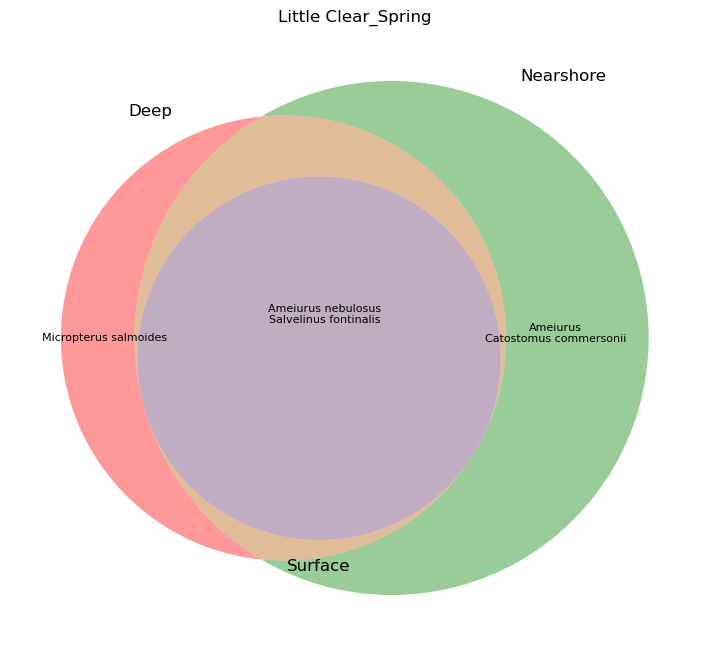

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

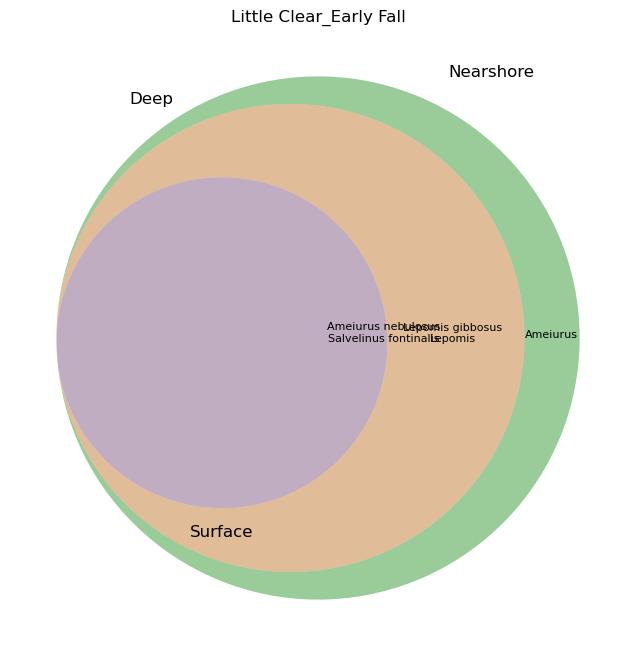

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

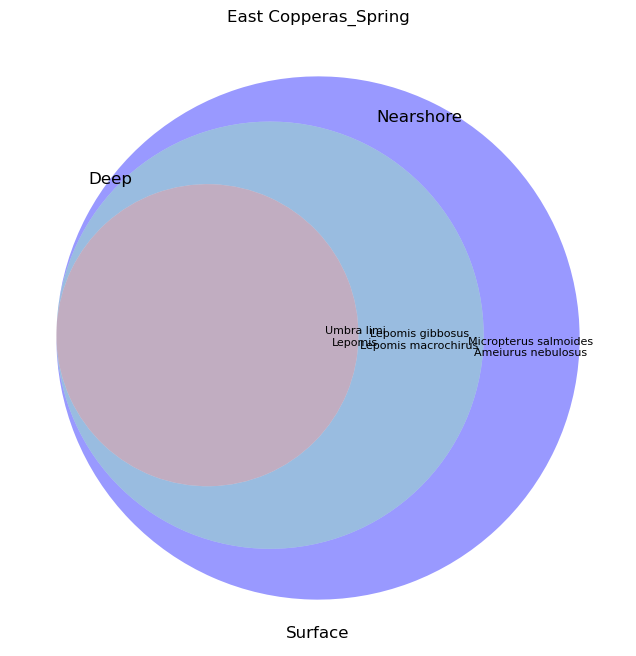

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

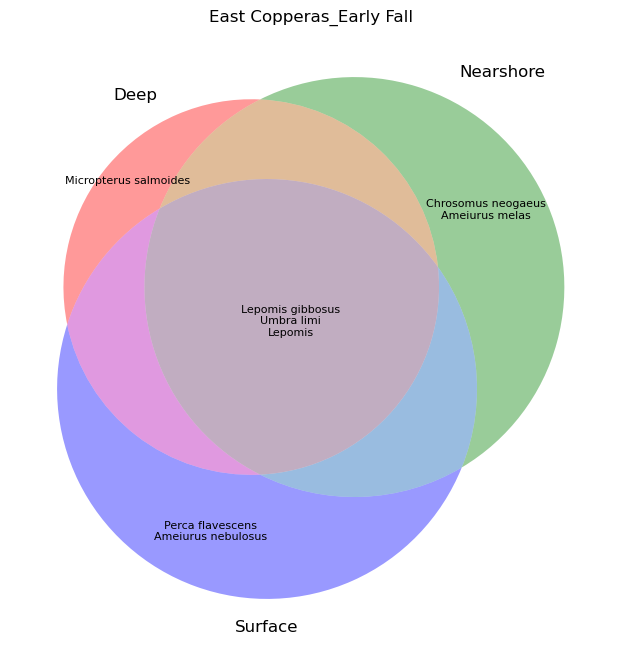

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

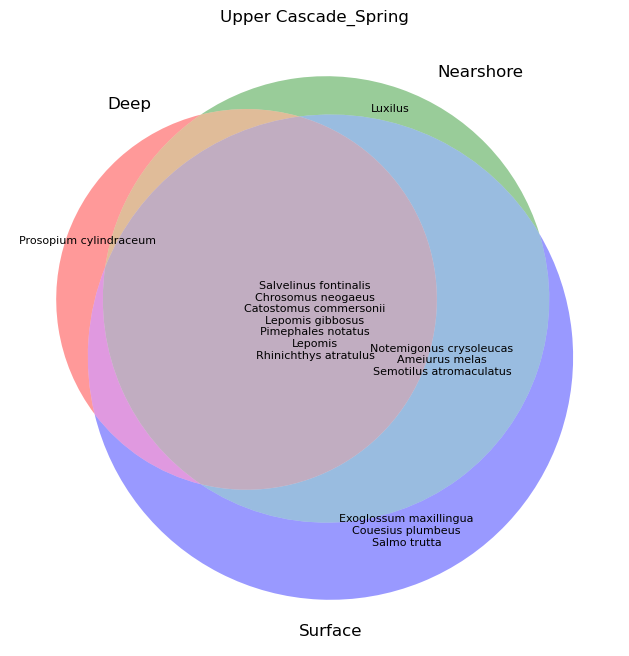

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

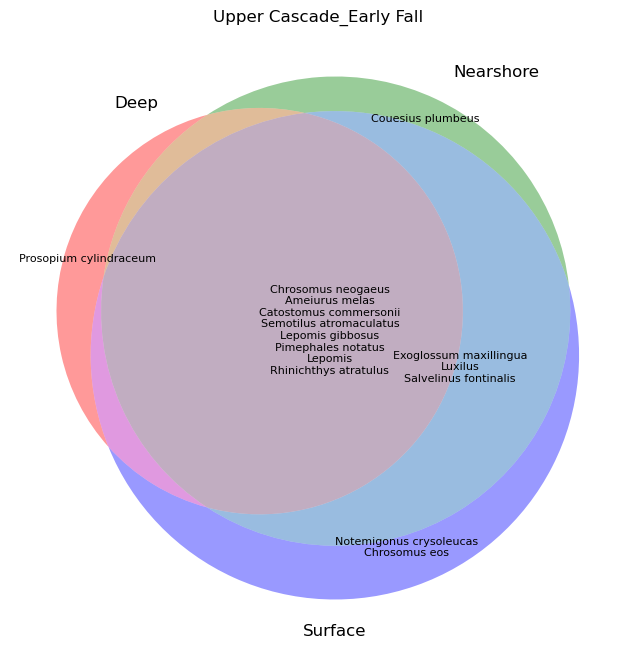

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

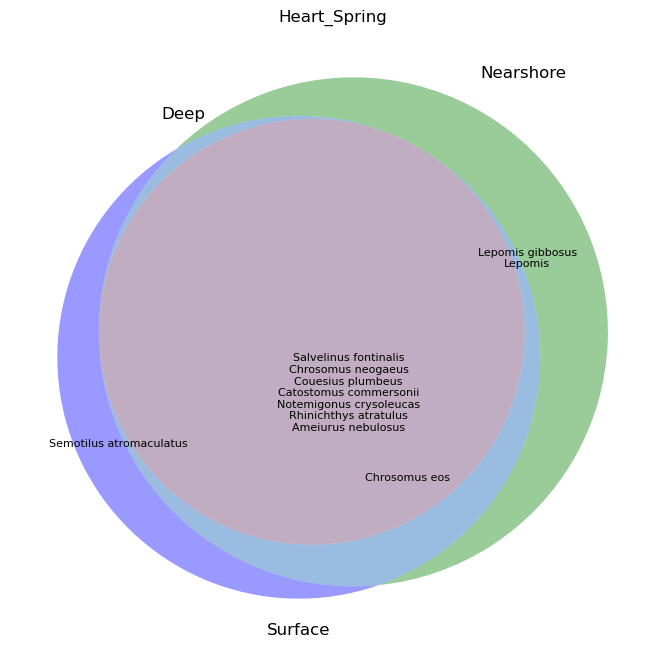

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

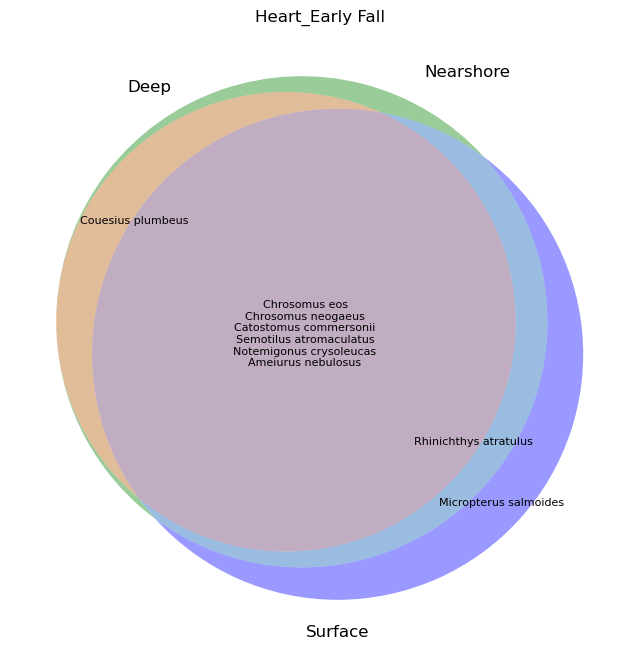

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

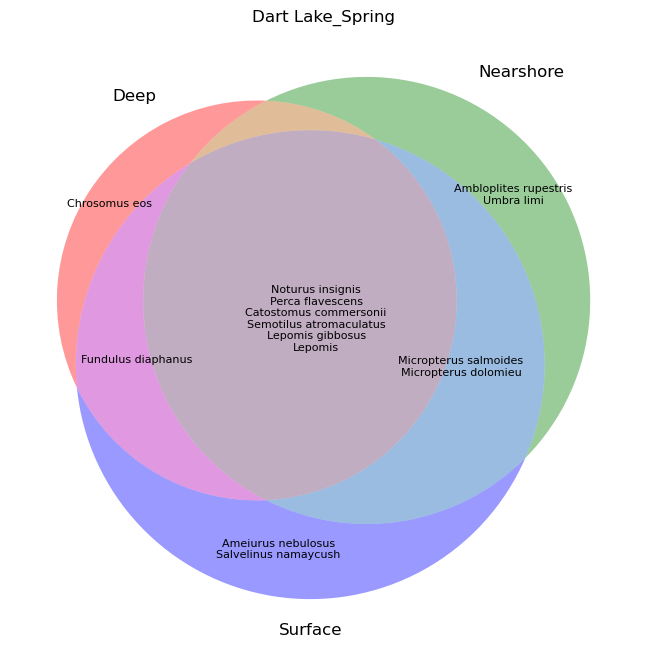

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

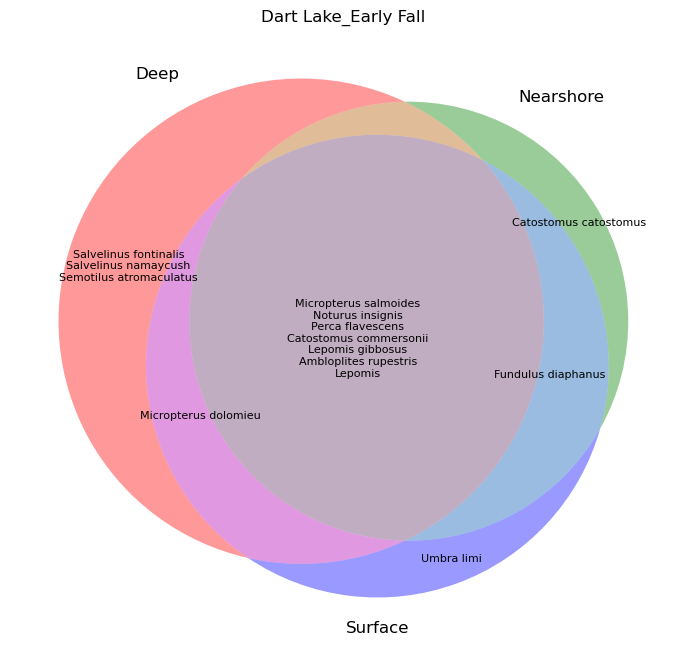

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

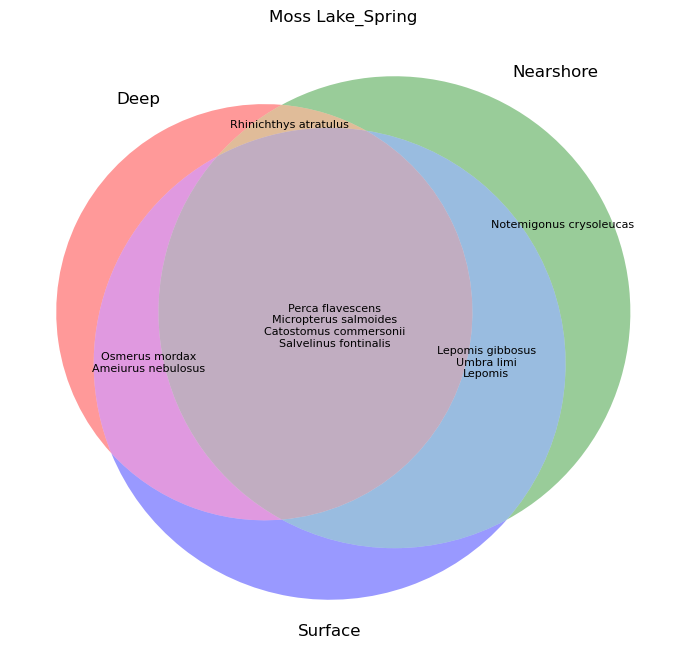

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

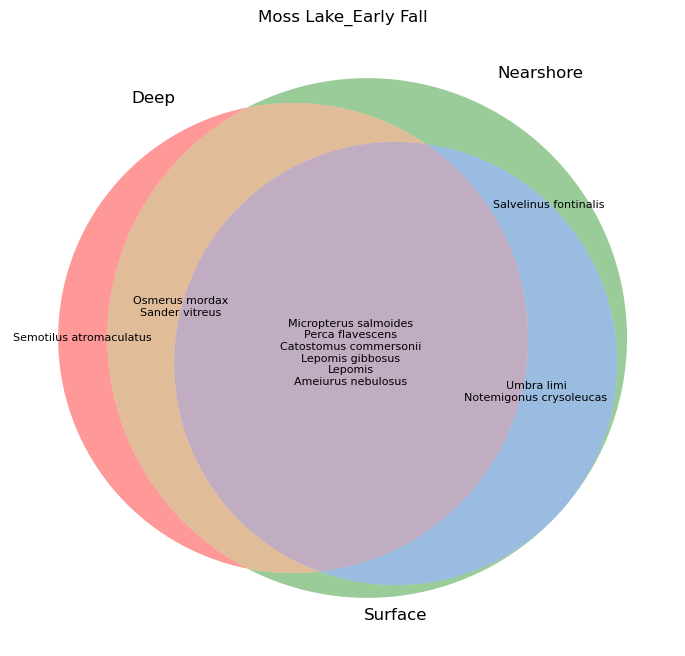

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

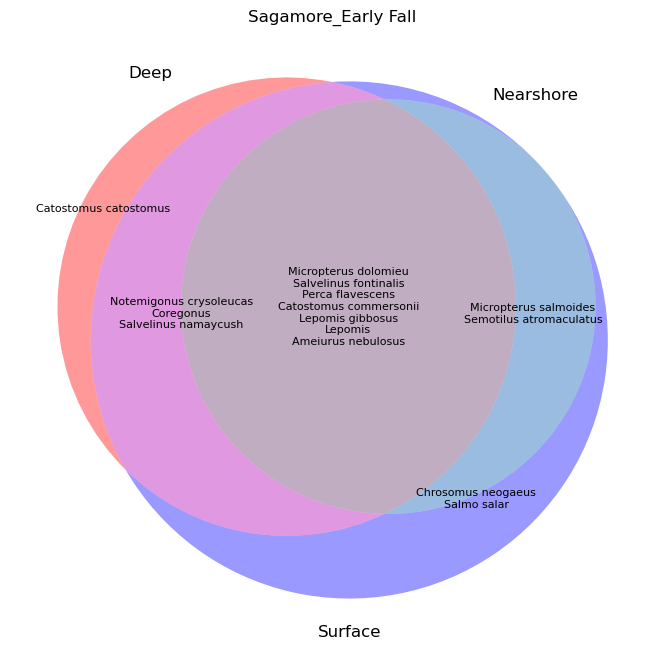

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

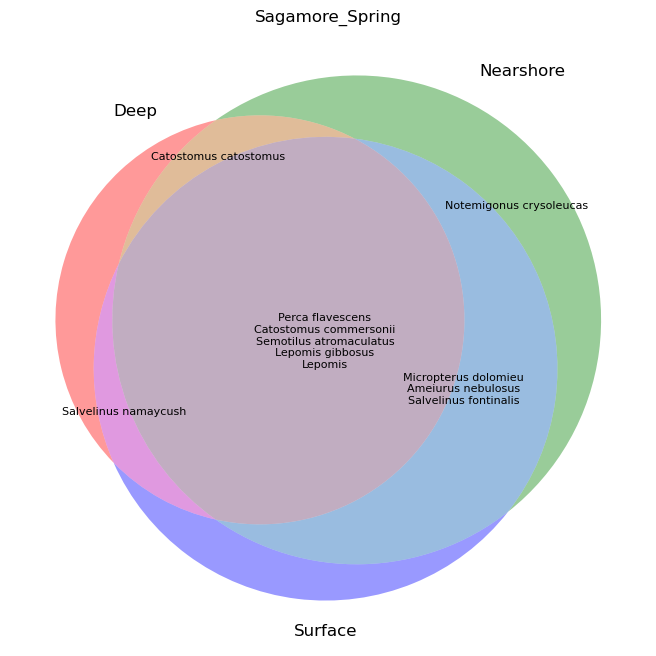

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

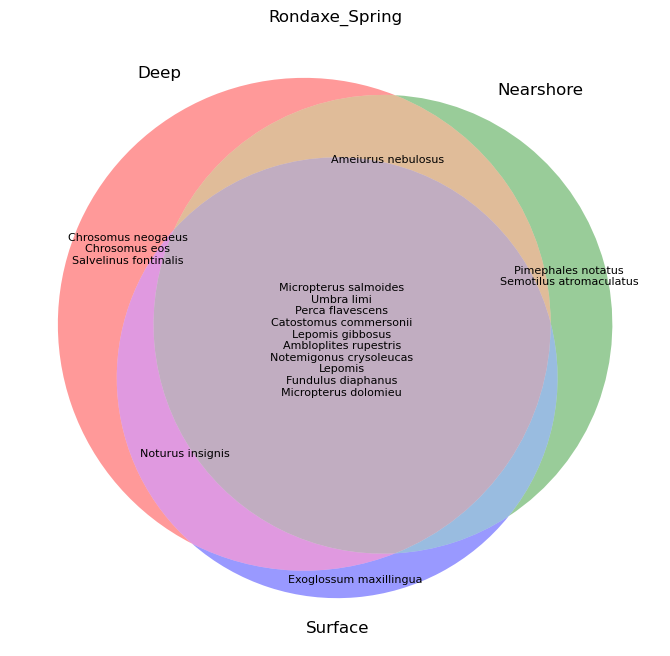

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

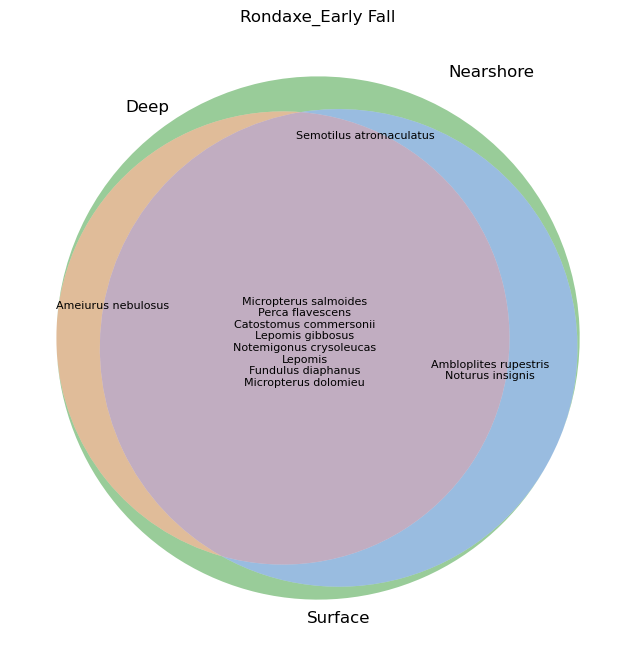

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

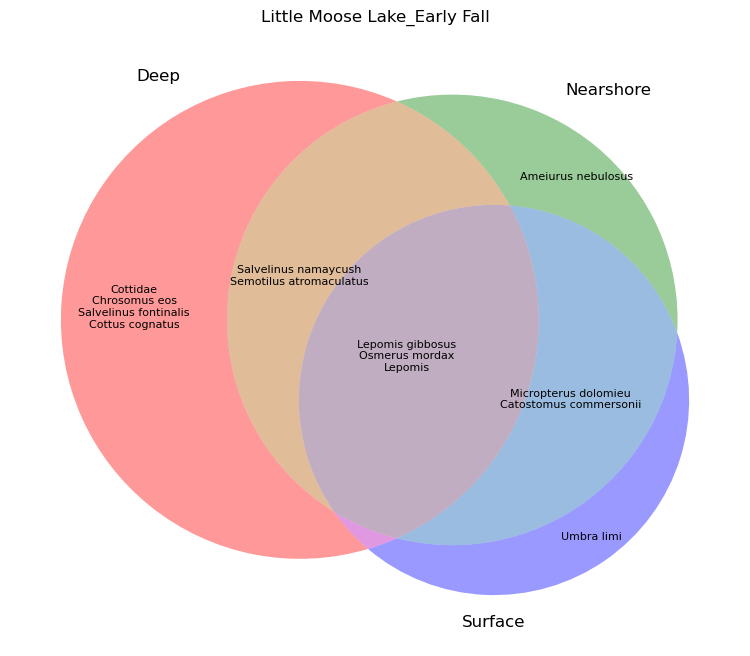

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

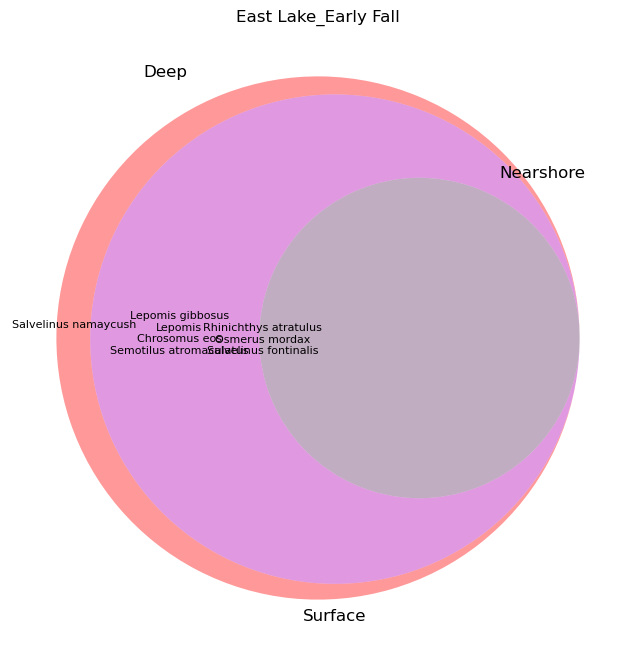

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

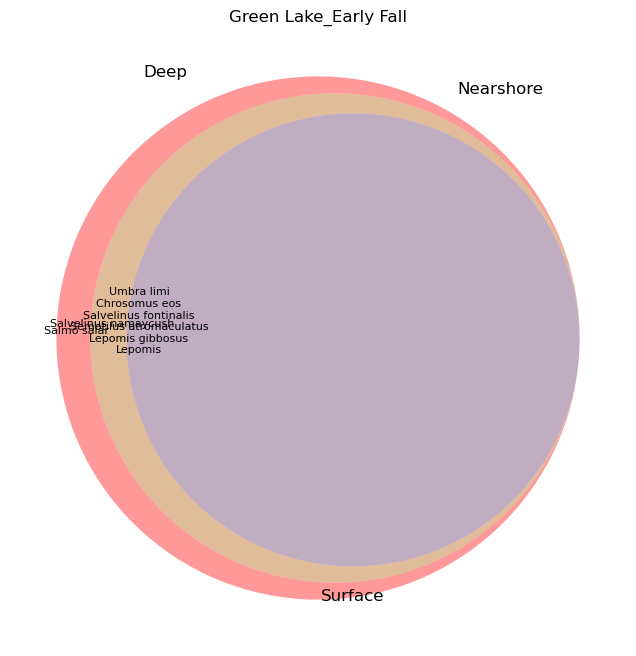

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

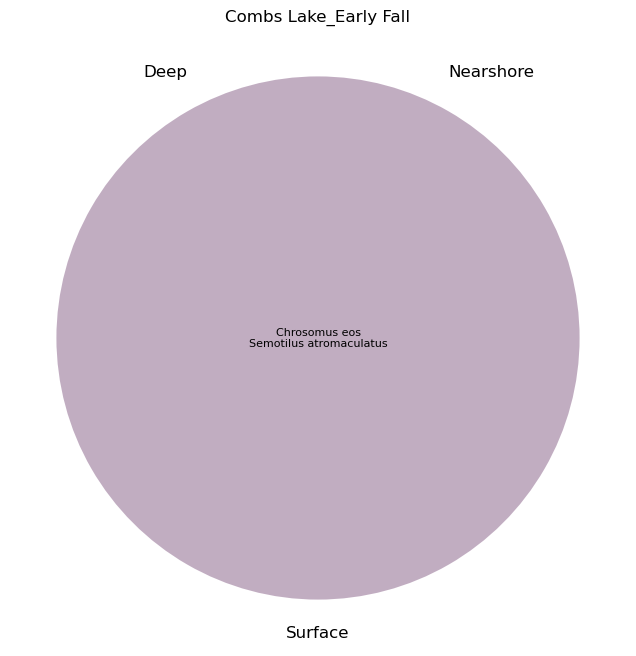

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

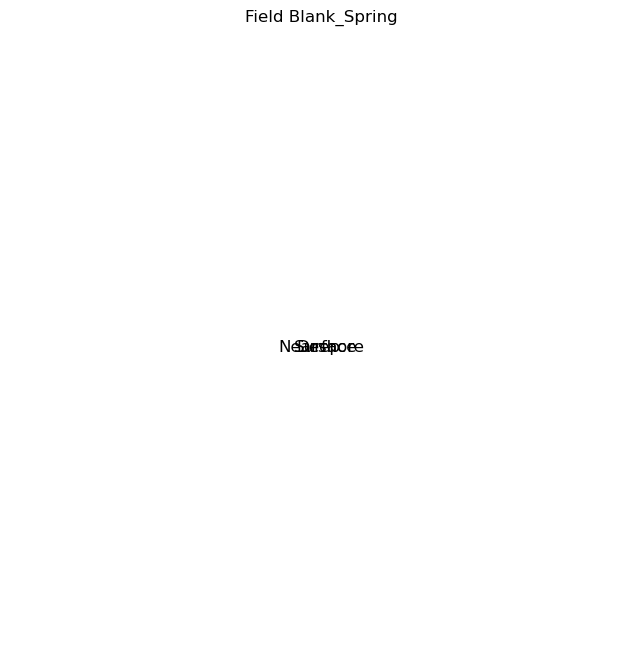

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

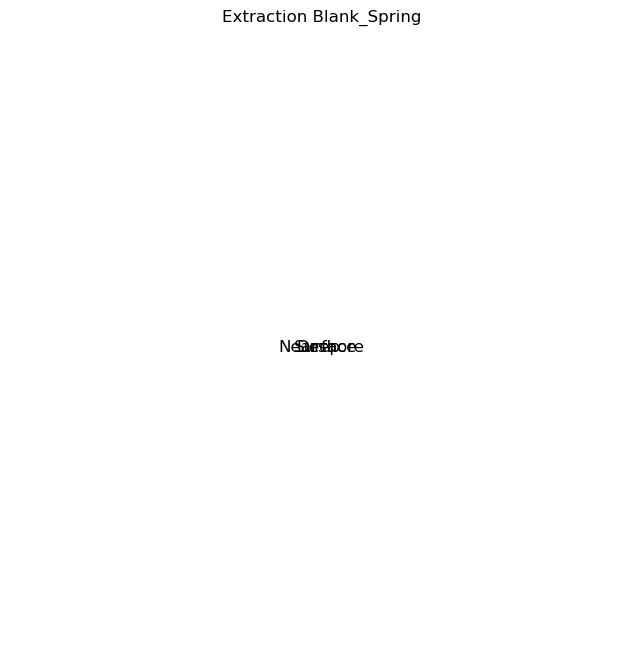

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

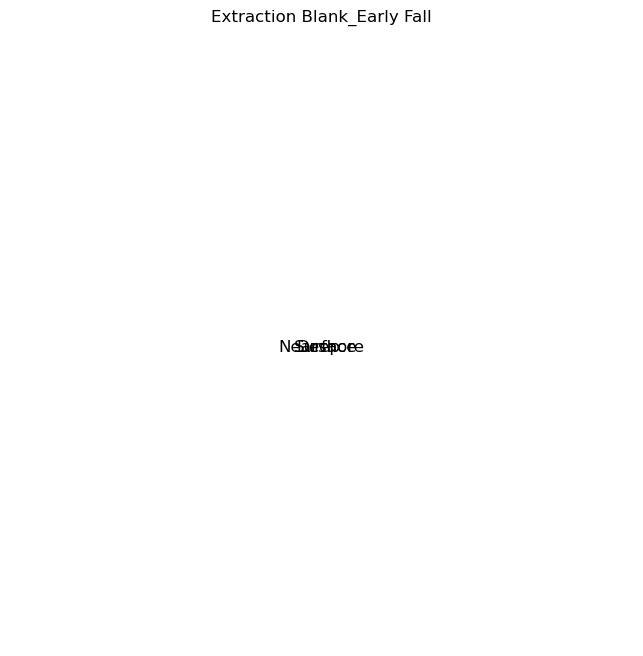

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

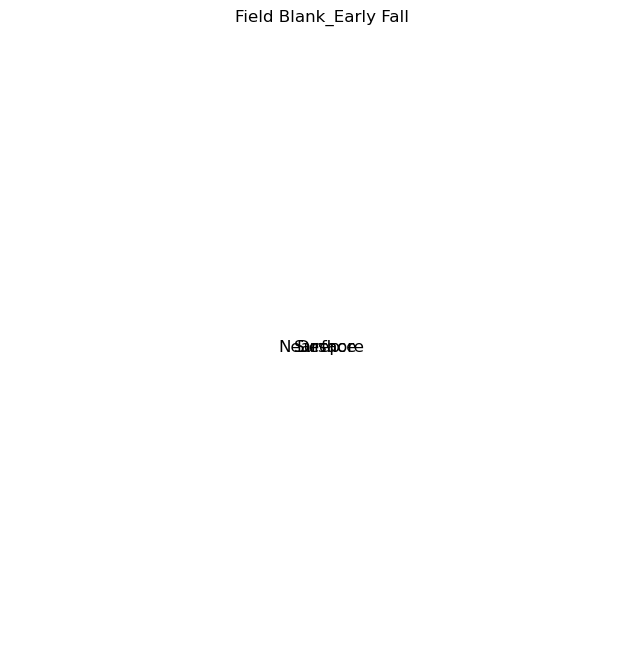

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

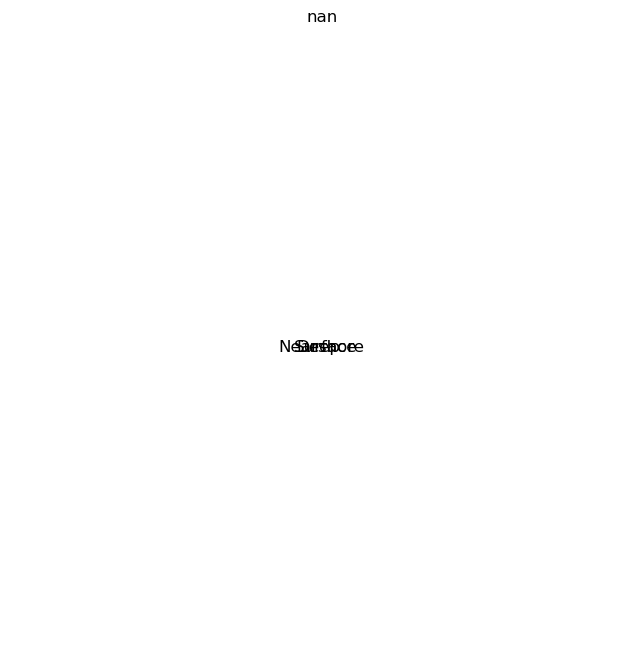

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3394888965.py:23: SettingWithCopyWa

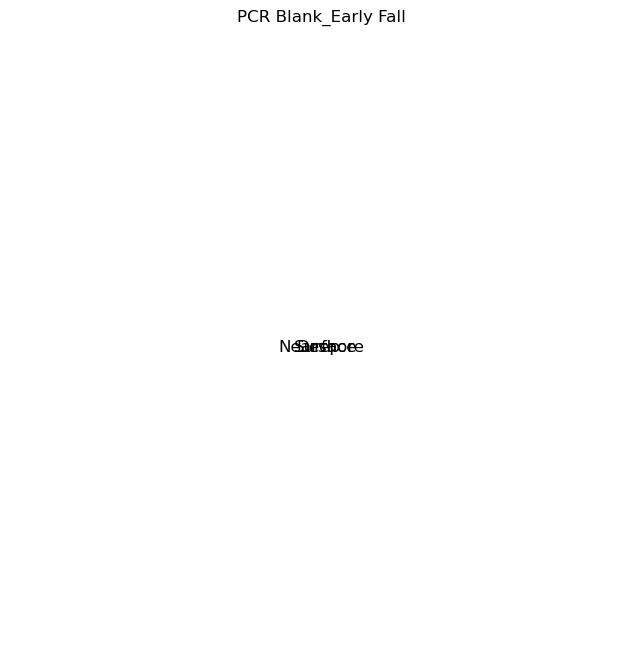

In [17]:
mifish = joined[joined["Primer"] == "MiFish"].reset_index(drop=True)
summary = pd.DataFrame()
for site_season in metadata["Merged"].unique().tolist():
    plt.figure(figsize=(10, 8))
    deep = (mifish[metadata["EGCF-ID"]
              [metadata["Merged"] == site_season]
              [metadata["Description"] == "Deep"].tolist() + 
              ["Overall_Best"]])
    deep["sum"] = deep[deep.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
    deep = deep[deep["sum"] > 0].reset_index(drop=True)
    deepsplist = deep["Overall_Best"].tolist()
    nearshore = (mifish[metadata["EGCF-ID"]
                  [metadata["Merged"] == site_season]
                  [metadata["Description"].isin(["Nearshore", "Near Shore"])].tolist() + 
                  ["Overall_Best"]])
    nearshore["sum"] = nearshore[nearshore.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
    nearshore = nearshore[nearshore["sum"] > 0].reset_index(drop=True)
    nearshoresplist = nearshore["Overall_Best"].tolist()
    surface = (mifish[metadata["EGCF-ID"]
                  [metadata["Merged"] == site_season]
                  [metadata["Description"] == "Surface"].tolist() + 
                  ["Overall_Best"]])
    surface["sum"] = surface[surface.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
    surface = surface[surface["sum"] > 0].reset_index(drop=True)
    surfacesplist = surface["Overall_Best"].tolist()
    deepsplist = set(deepsplist)
    nearshoresplist = set(nearshoresplist)
    surfacesplist = set(surfacesplist)

    # Define your species sets for three habitats
    # Plot the Venn diagram
    venn = venn3([deepsplist, 
                  nearshoresplist, 
                  surfacesplist], 
                 ('Deep', 'Nearshore', 'Surface'))
    tmp7 = pd.DataFrame(data = [len(deepsplist - nearshoresplist - surfacesplist), 
                                len(nearshoresplist - deepsplist - surfacesplist), 
                                len(surfacesplist - deepsplist - nearshoresplist), 
                                len((deepsplist & nearshoresplist) - surfacesplist), 
                                len((deepsplist & surfacesplist) - nearshoresplist), 
                                len((nearshoresplist & surfacesplist) - deepsplist), 
                                len(deepsplist & nearshoresplist & surfacesplist)]).T
    tmp7.columns = ["deeponly", "nearshoreonly", "shallowonly", "deepnearshore", "deepsurface", "nearshoresurface", "intersectall"]
    tmp7["lake"] = site_season
    summary = pd.concat([summary, tmp7]).reset_index(drop=True)

    # Now manually set the labels for each subset
    # The subsets are labeled by region IDs, like '100', '010', '001', '110', etc.
    try:   # Example for region '100' (only in A)
        venn.get_label_by_id('100').set_text('\n'.join(deepsplist - nearshoresplist - surfacesplist))
    except:
        pass
    # Only in B
    try:
        venn.get_label_by_id('010').set_text('\n'.join(nearshoresplist - deepsplist - surfacesplist))
    except:
        pass
    # Only in C
    try:
        venn.get_label_by_id('001').set_text('\n'.join(surfacesplist - deepsplist - nearshoresplist))
    except:
        pass
    # In A and B, but not C
    try:
        venn.get_label_by_id('110').set_text('\n'.join((deepsplist & nearshoresplist) - surfacesplist))
    except:
        pass
    # In A and C, but not B
    try:
        venn.get_label_by_id('101').set_text('\n'.join((deepsplist & surfacesplist) - nearshoresplist))
    except:
        pass
    # In B and C, but not A
    try:
        venn.get_label_by_id('011').set_text('\n'.join((nearshoresplist & surfacesplist) - deepsplist))
    except:
        pass
    # In all three
    try:
        venn.get_label_by_id('111').set_text('\n'.join(deepsplist & nearshoresplist & surfacesplist))
    except:
        pass
    for subset in ('100', '010', '001', '110', '101', '011', '111'):
        label = venn.get_label_by_id(subset)
        if label:  # Some regions may be empty
            label.set_fontsize(8)

    plt.title(site_season)
    plt.show()

In [18]:
summary["total"] = (summary["deeponly"] + summary["nearshoreonly"] + summary["shallowonly"] + 
                summary["deepnearshore"] + summary["deepsurface"]  + summary["nearshoresurface"] + summary["intersectall"])
for i in summary.columns.tolist()[0:7]:
    summary[i + "percent"] = summary[i] / summary["total"]

In [19]:
summary = summary[summary["lake"].notna()].reset_index(drop=True)

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


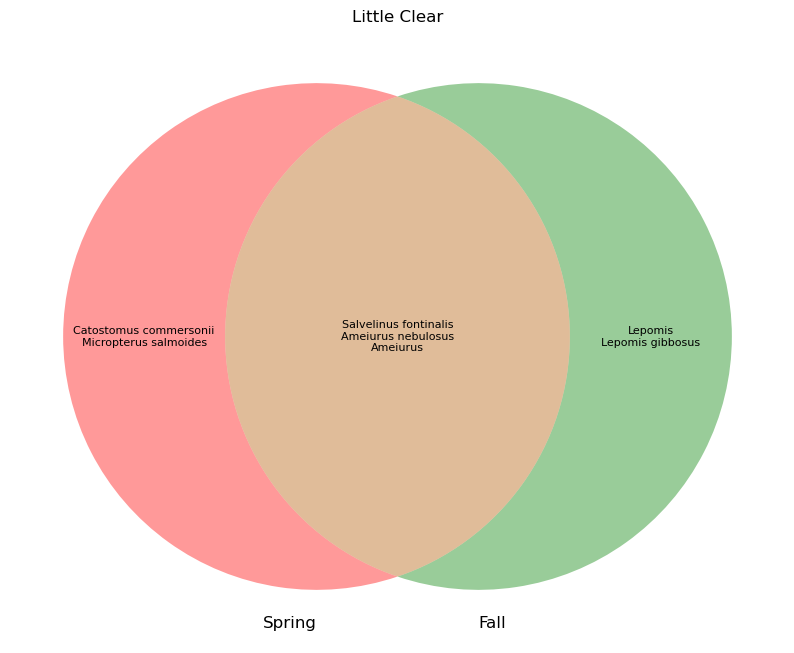

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


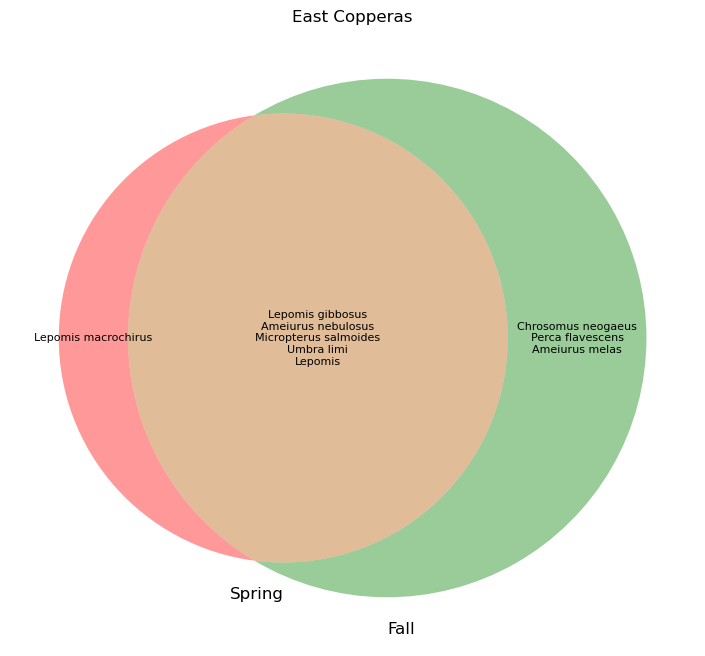

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


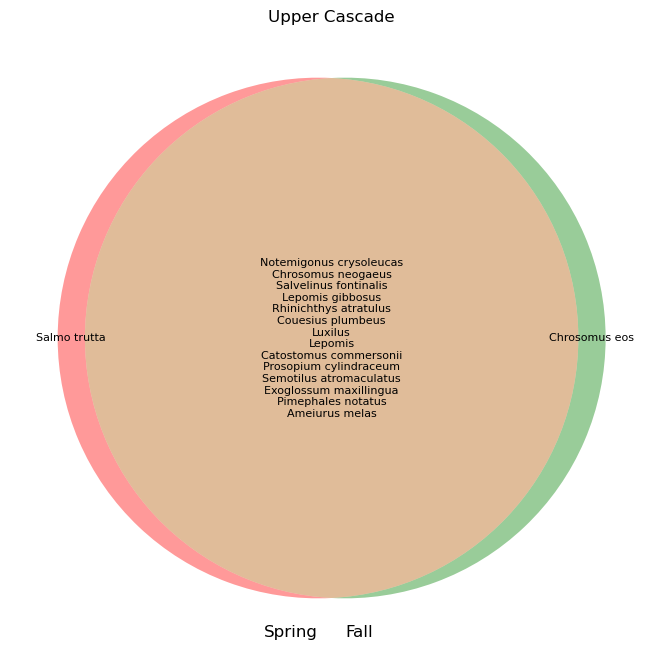

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


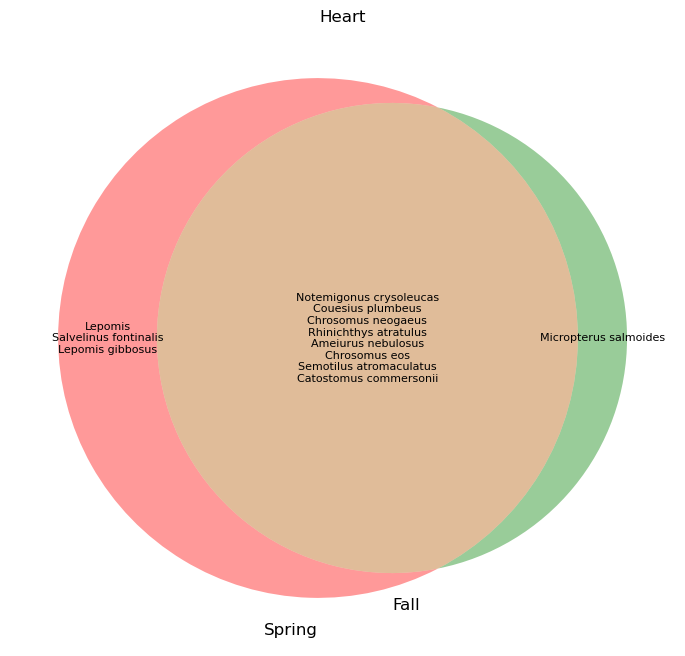

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


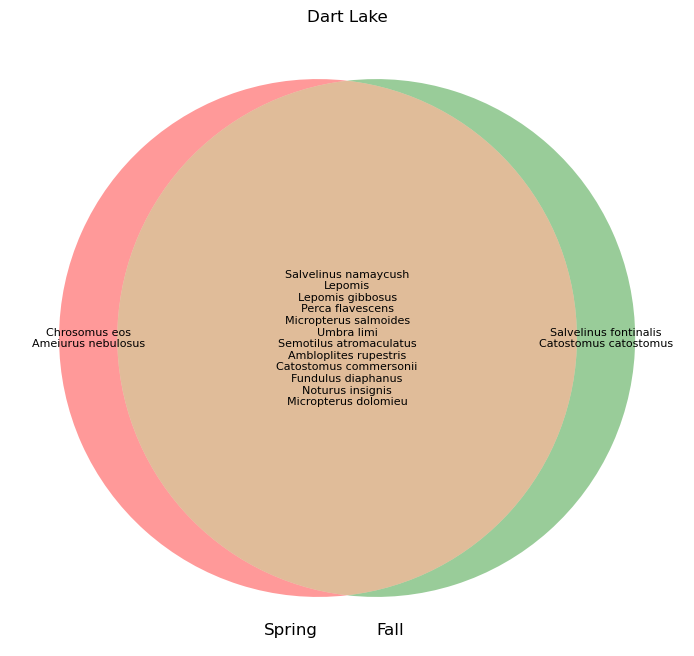

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


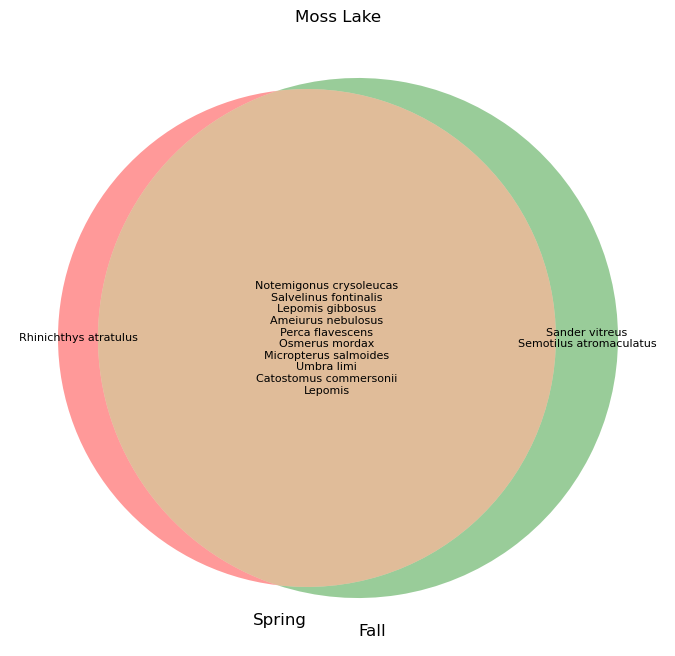

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


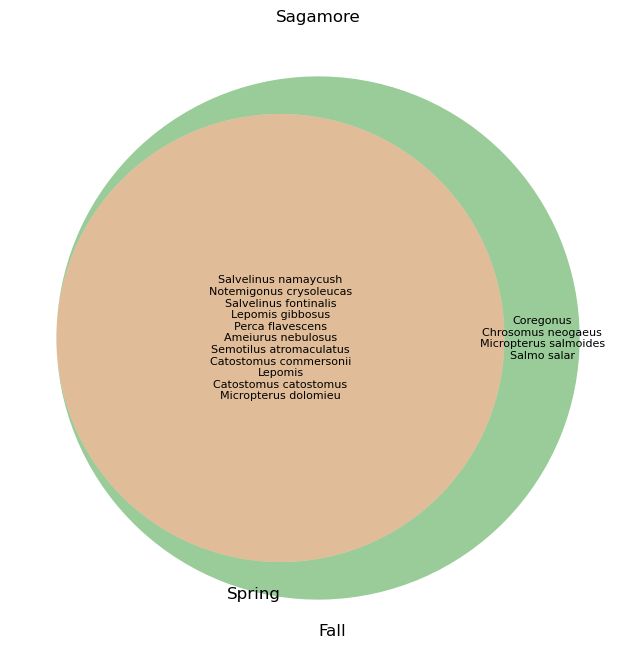

/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
/fs/dss/scratch/7125030_noge4093_mpcs047/ipykernel_3211142/1902295249.py:34: SettingWithCopyWarning: 


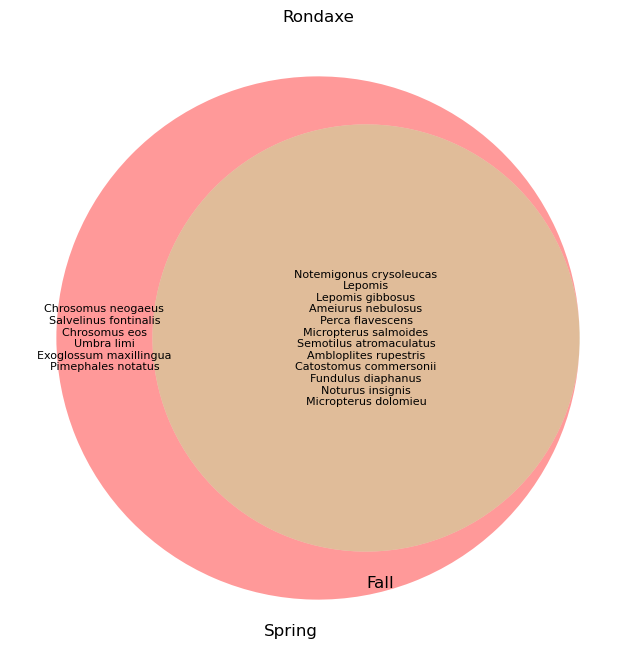

In [41]:
typeclassification = pd.DataFrame()
summary = pd.DataFrame()
mifish = joined[joined["Primer"] == "MiFish"].reset_index(drop=True)
for site_season in ['Little Clear',
 'East Copperas',
 'Upper Cascade',
 'Heart',
 'Dart Lake',
 'Moss Lake',
 'Sagamore',
 'Rondaxe']:
    if len(metadata["Season"][metadata["Name"] == site_season].unique()) > 0:
        plt.figure(figsize=(10, 8))
        spring = (mifish[metadata["EGCF-ID"]
                  [metadata["Name"] == site_season]
                  [metadata["Season"] == "Spring"].tolist() + 
                  ["Overall_Best"]])
        spring["sum"] = spring[spring.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
        spring = spring[spring["sum"] > 0].reset_index(drop=True)
        springsplist = spring["Overall_Best"].tolist()
        fall = (mifish[metadata["EGCF-ID"]
                  [metadata["Name"] == site_season]
                  [metadata["Season"] == "Early Fall"].tolist() + 
                  ["Overall_Best"]])
        fall["sum"] = fall[fall.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
        fall = fall[fall["sum"] > 0].reset_index(drop=True)
        fallsplist = fall["Overall_Best"].tolist()
        
        springsplist = set(springsplist)
        fallsplist = set(fallsplist)
        allyear = (mifish[metadata["EGCF-ID"]
                  [metadata["Name"] == site_season].tolist() + 
                  ["Overall_Best"]])
        allyear["sum"] = allyear[allyear.columns[0:-1].tolist()].sum(axis=1, numeric_only=True)
        allyear = allyear[allyear["sum"] > 0].reset_index(drop=True)
        allyear["nsites"] = allyear[allyear.columns[0:-2].tolist()].gt(0).sum(axis=1)
        allyearsplist = allyear["Overall_Best"].tolist()
        allyear["Classification"] = "Unclassified"
        for spp in range(len(allyear)):
            if allyear["nsites"][spp] == 1:
                if allyear["Overall_Best"][spp] in fallsplist:
                    allyear["Classification"][spp] = "Fall Ephemeral"
                if allyear["Overall_Best"][spp] in springsplist:
                    allyear["Classification"][spp] = "Spring Ephemeral"
            elif allyear["nsites"][spp] > 1:
                if allyear["Overall_Best"][spp] in (fallsplist - springsplist):
                    allyear["Classification"][spp] = "Fall Resident"
                if allyear["Overall_Best"][spp] in (springsplist - fallsplist):
                    allyear["Classification"][spp] = "Spring Resident"
                if allyear["Overall_Best"][spp] in (fallsplist & springsplist):
                    allyear["Classification"][spp] = "Year-round Resident"
            if allyear["nsites"][spp] <= (0.1* len(metadata[metadata["Name"] == site_season])):
                if allyear["Overall_Best"][spp] in (fallsplist & springsplist):
                    allyear["Classification"][spp] = "Rare Year-round Resident"
        tmp = allyear[['Overall_Best', 'sum', 'nsites', 'Classification']]
        tmp["Lake"] = site_season
        tmp7 = pd.DataFrame(data = [len(springsplist - fallsplist), len(fallsplist - springsplist), len(fallsplist & springsplist)]).T
        tmp7.columns = ["springonly", "fallonly", "intersect"]
        tmp7["lake"] = site_season
        summary = pd.concat([summary, tmp7]).reset_index(drop=True)
        typeclassification = pd.concat([typeclassification, tmp]).reset_index(drop=True)
                # Define your species sets for three habitats
        # Plot the Venn diagram
        venn = venn2([springsplist, 
                      fallsplist], 
                     ('Spring', 'Fall'))

        # Now manually set the labels for each subset
        # The subsets are labeled by region IDs, like '100', '010', '001', '110', etc.
        try:   # Example for region '100' (only in A)
            venn.get_label_by_id('10').set_text('\n'.join(springsplist - fallsplist))
        except:
            pass
        try:
            venn.get_label_by_id('01').set_text('\n'.join(fallsplist - springsplist))
        except:
            pass
        try:
            venn.get_label_by_id('11').set_text('\n'.join(fallsplist & springsplist))
        except:
            pass
        for subset in ('10', '01', '11'):
            label = venn.get_label_by_id(subset)
            if label:  # Some regions may be empty
                label.set_fontsize(8)

        plt.title(site_season)
        plt.show()

In [ ]:
summary["total"] = summary["springonly"] + summary["fallonly"] + summary["intersect"] 
summary["springpercent"] = summary["springonly"] / summary["total"]
summary["fallpercent"] = summary["fallonly"] / summary["total"]
summary["intersectpercent"] = summary["intersect"] / summary["total"]

In [ ]:
typeclassification = (typeclassification
                      [typeclassification["Overall_Best"] != "Lepomis"].reset_index(drop=True))

In [ ]:
size_migration = pd.DataFrame()
for i in typeclassification["Lake"].unique().tolist():
    tmp = pd.DataFrame(data = [i, (len(typeclassification[typeclassification["Lake"] == i]
                  [typeclassification["Classification"] == "Year-round Resident"]) / 
              len(typeclassification[typeclassification["Lake"] == i]))]).T
    tmp.columns = ["Name", "Percentage Resident"]
    size_migration = pd.concat([tmp, size_migration]).reset_index(drop=True)

In [ ]:
edna_spp = typeclassification.copy()
edna_spp.columns = ["Species", "Reads", "Nsites", "Classification", "Name"]
edna_spp["Year"] = 2023

In [22]:
new_spp_list = pd.concat([historical_spp, edna_spp]).reset_index(drop=True)
new_spp_list.loc[new_spp_list["Classification"].isna(), "Classification"] = "Catch"
new_spp_list["sort"] = np.nan
new_spp_list.loc[new_spp_list["Classification"] == "Catch", "sort"] = 0
new_spp_list.loc[new_spp_list["Classification"] == "Year-round Resident", "sort"] = 6
new_spp_list.loc[new_spp_list["Classification"] == "Rare Year-round Resident", "sort"] = 5
new_spp_list.loc[new_spp_list["Classification"] == 'Spring Resident', "sort"] = 4
new_spp_list.loc[new_spp_list["Classification"] == 'Spring Ephemeral', "sort"] = 3
new_spp_list.loc[new_spp_list["Classification"] == "Fall Resident", "sort"] = 2
new_spp_list.loc[new_spp_list["Classification"] == "Fall Ephemeral", "sort"] = 1
new_spp_list.loc[new_spp_list["Surveyor"] == "AFRP", "Year"] = 2022
new_spp_list = new_spp_list.loc[new_spp_list["Species"] != "Ameirus"].reset_index(drop=True)
new_spp_list.loc[new_spp_list["Species"] == "Coregonus", "Species"] = "Coregonus clupeaformis"
new_spp_list.loc[new_spp_list["Species"] == "Cottidae", "Species"] = "Cottus cognatus"
new_spp_list.loc[new_spp_list["Species"] == "Luxilus", "Species"] = "Luxilus cornatus"

In [27]:
new_spp_list = new_spp_list.drop_duplicates(["Name", "Year", "Species"]).reset_index(drop=True)

In [28]:
df = new_spp_list.sort_values("sort").reset_index(drop=True).copy()
# Define your categorical confidence levels and their order
confidence_levels = ['Catch', 
 'Year-round Resident',
 'Rare Year-round Resident',
 'Spring Resident',
 'Spring Ephemeral',
 'Fall Resident',
 'Fall Ephemeral'
]

# Map confidence levels to integers
confidence_map = {level: i for i, level in enumerate(confidence_levels)}
df['confidence_num'] = df['Classification'].map(confidence_map)

In [132]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# Define colors
grey_color = "#5c5c5c"  # Grey for -1 < x < 0
start_color = "#305b37"
end_color = "#305b37"

# Create a segmented colormap
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, grey_color), (0.5, grey_color), (0.5, start_color), (1, end_color)]
)

In [133]:
df["Fraction"] = np.nan
for i in df.Name.unique().tolist():
    df.loc[(df["Name"] == i) & (df["Classification"] != "Catch"), "Fraction"] = df["Nsites"] / df["Nsites"][df["Name"] == i][df["Classification"] != "Catch"].max()

In [134]:
df.loc[df["Fraction"].isna(), "Fraction"] = -1

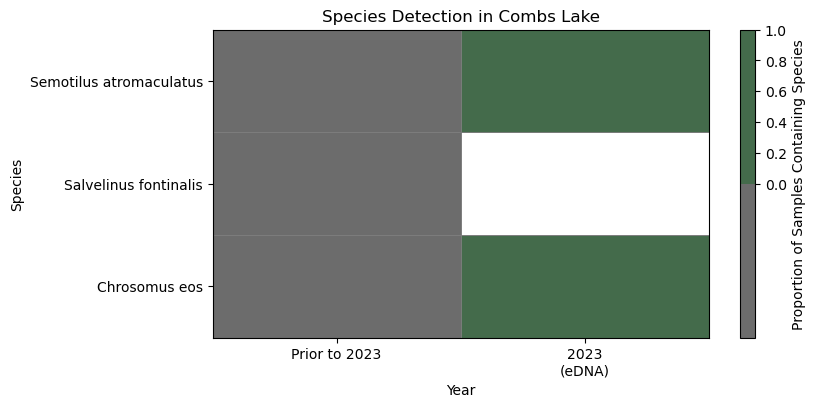

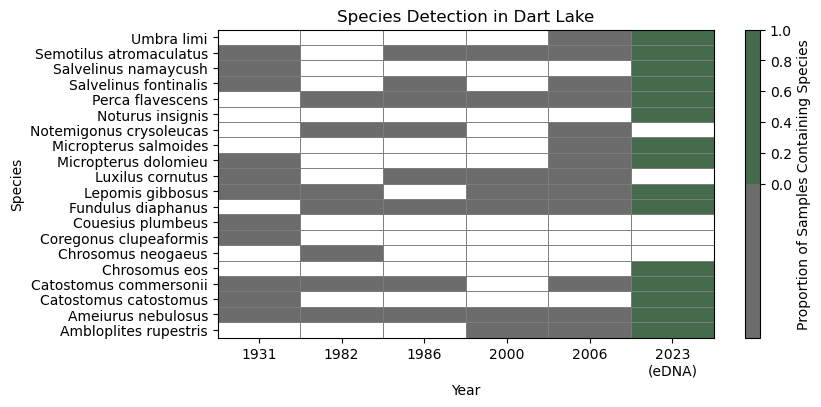

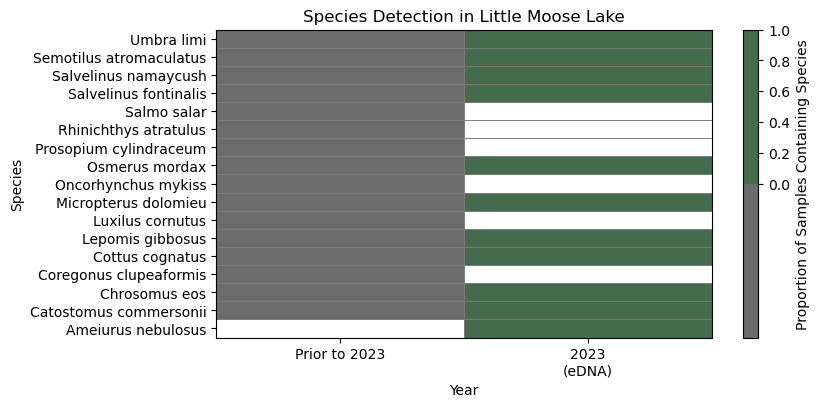

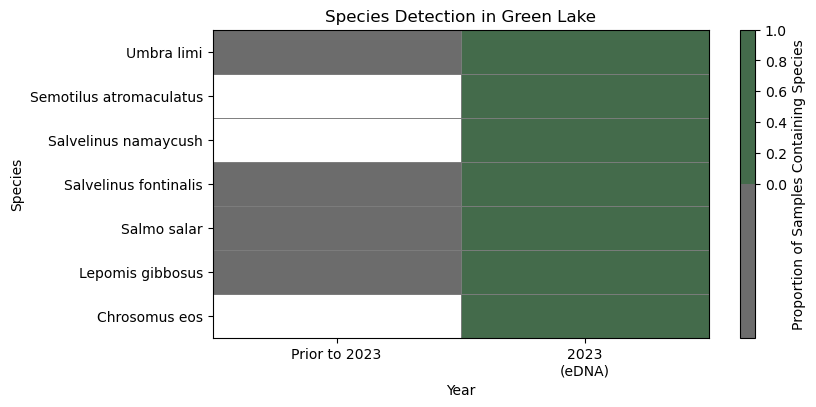

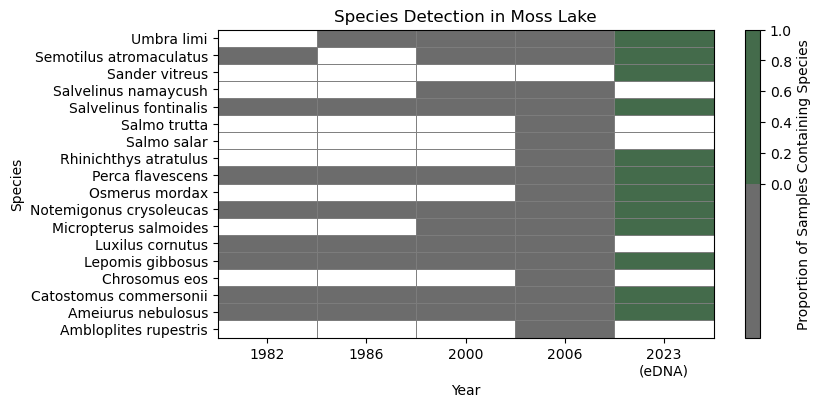

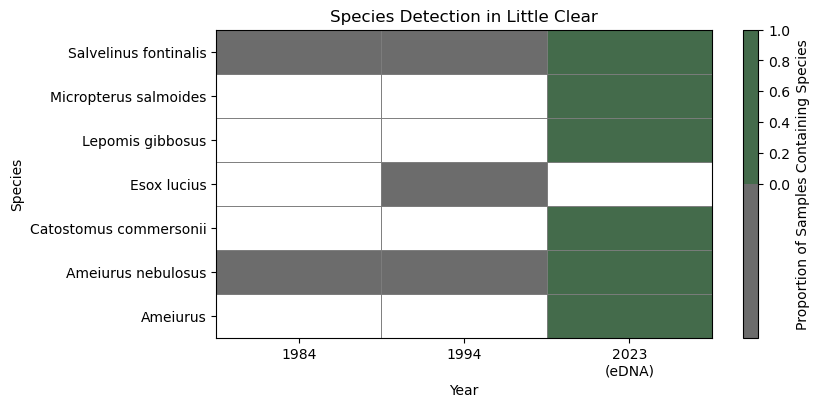

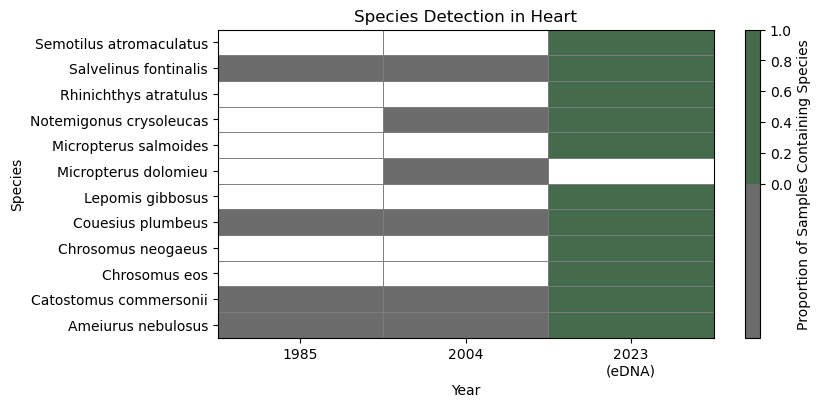

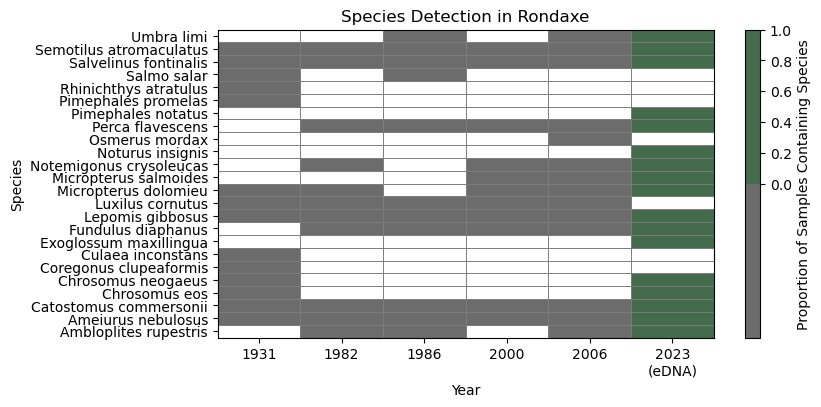

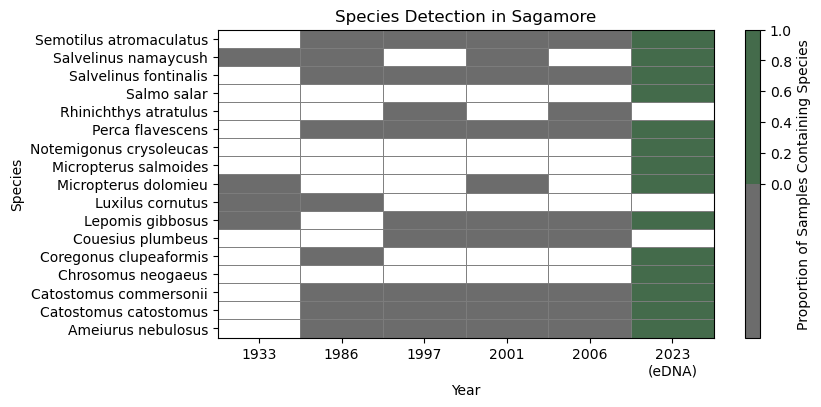

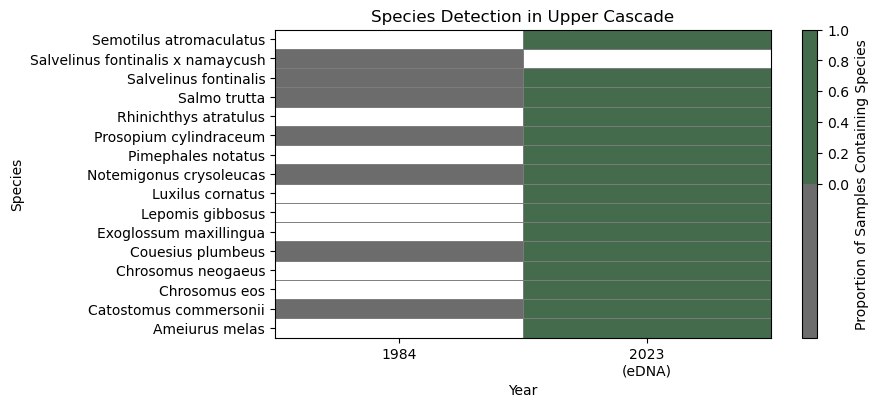

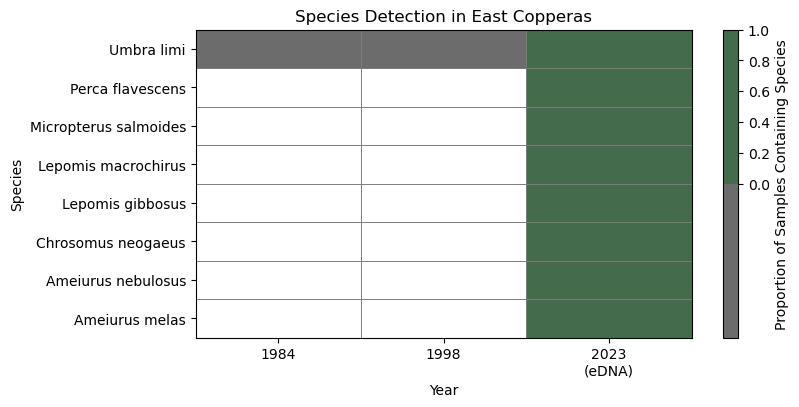

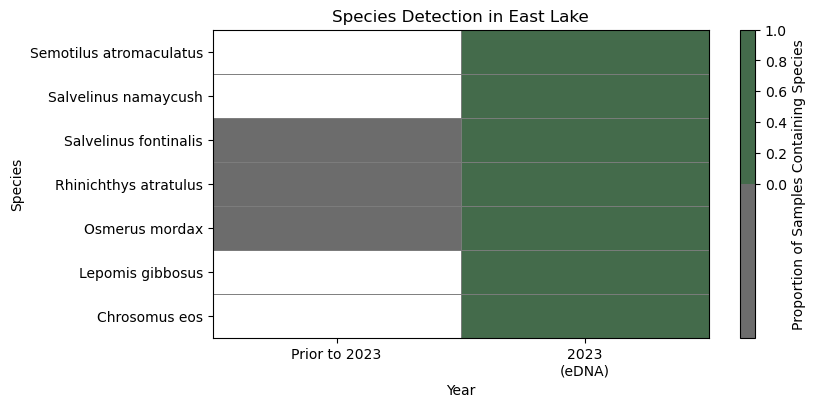

In [135]:
for lake_name in df.Name.unique():
    # Now create a pivot table: species as rows, years as columns, values as confidence category numbers
    lake_df = df[df['Name'] == lake_name].sort_values(["Species", "Fraction"], ascending = [False, True]).reset_index(drop=True)

    pivot = lake_df.pivot(index='Species', columns='Year', values='Fraction')

    # Set normalization boundaries between each category
    bounds = np.arange(len(confidence_levels) + 1) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot
    plt.figure(figsize=(8, 4))
    heatmap = plt.pcolormesh(pivot.values, cmap=cmap, edgecolors='gray',# norm=norm, 
                             linewidth=0.5, shading='auto', alpha = 0.9)

    # Set ticks and labels
    if lake_name in ['East Lake', 'Green Lake', 'Combs Lake', 'Little Moose Lake']:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=["Prior to 2023", "2023\n(eDNA)"])
    else:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=pivot.columns.tolist()[0:-1] + ["2023\n(eDNA)"])
    plt.yticks(ticks=np.arange(len(pivot.index)) + 0.5, labels=pivot.index)
    plt.title(f'Species Detection in {lake_name}')
    plt.xlabel('Year')
    plt.ylabel('Species')

    # Add a colorbar with confidence levels
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Proportion of Samples Containing Species')
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.savefig("../" + lake_name + "_change_nsamples_color.pdf", dpi = 300,bbox_inches='tight')
    plt.savefig("../" + lake_name + "_change_nsamples_color.jpg", dpi = 300,bbox_inches='tight')

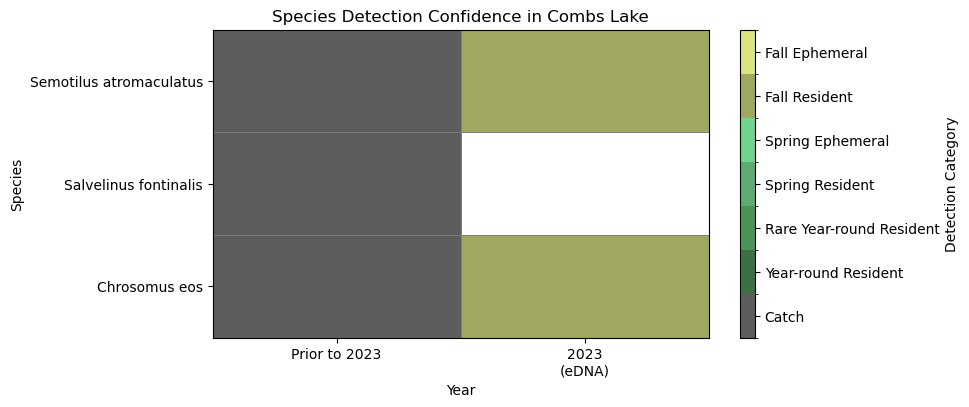

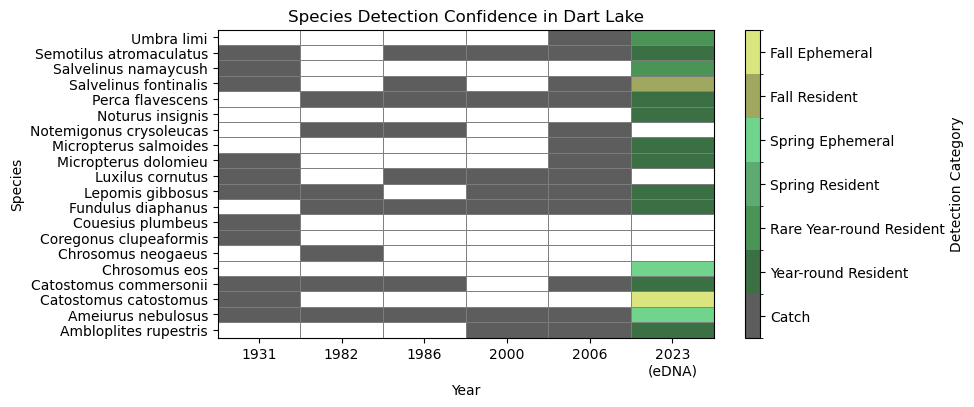

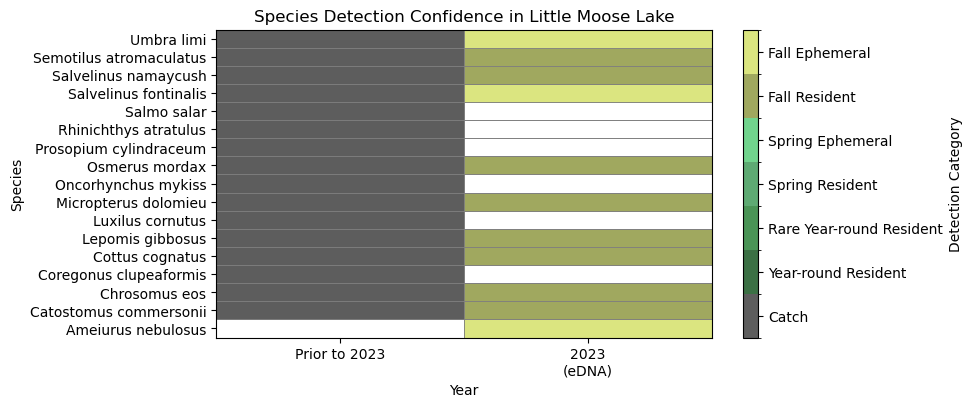

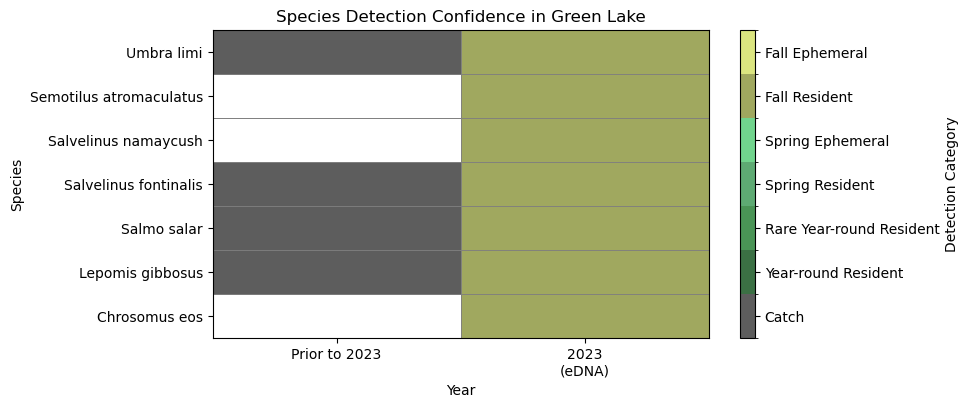

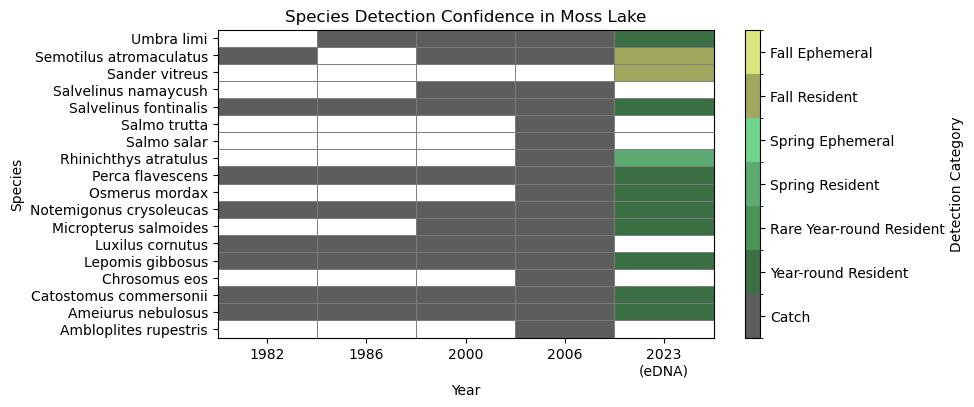

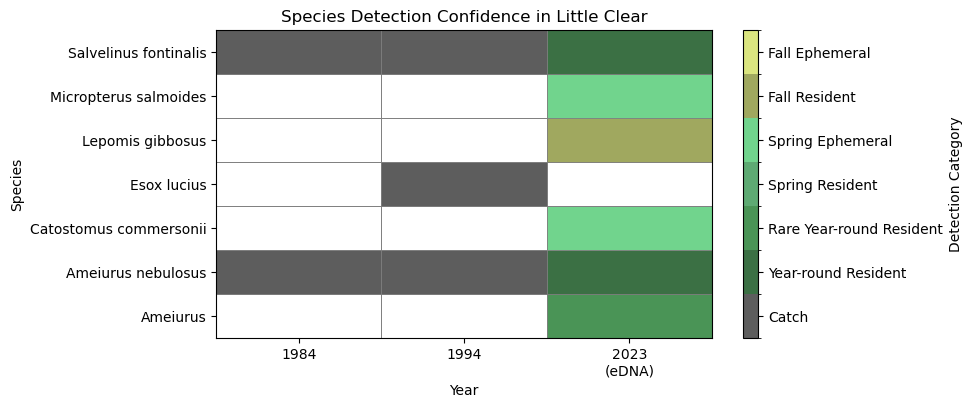

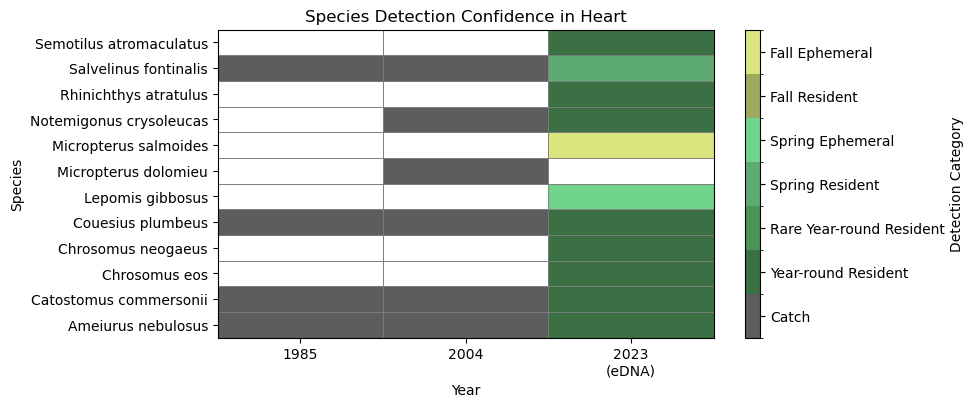

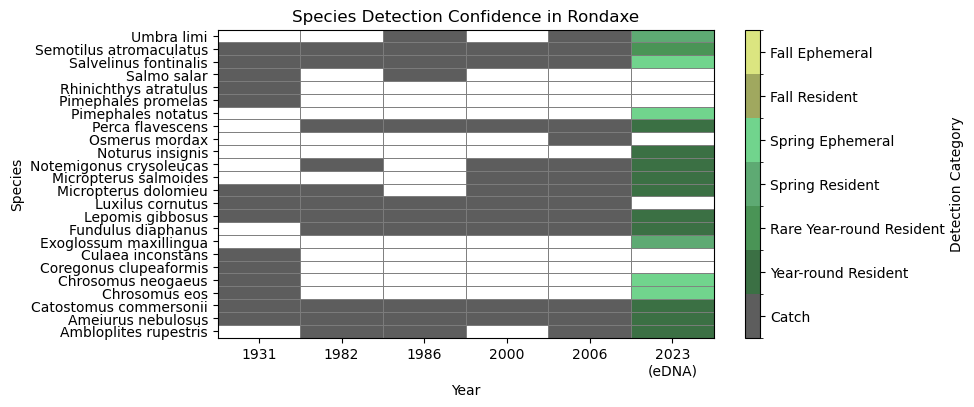

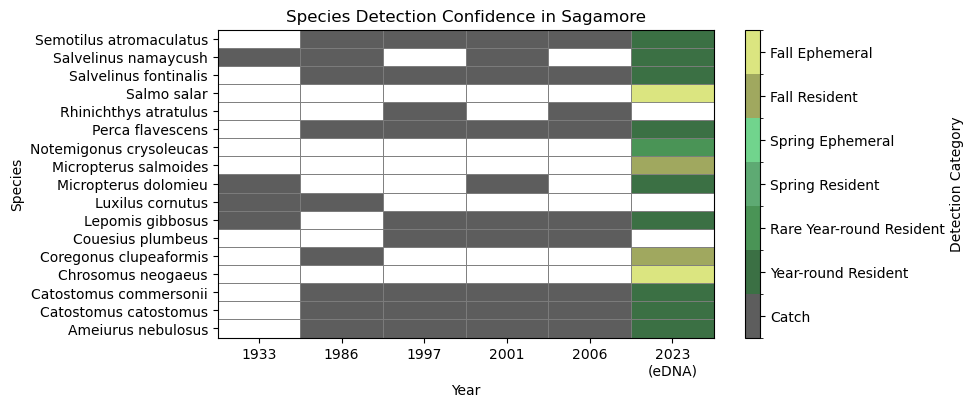

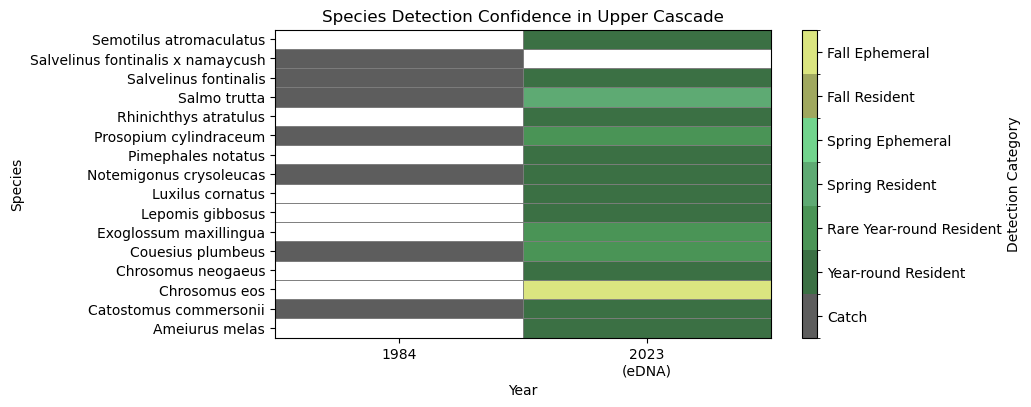

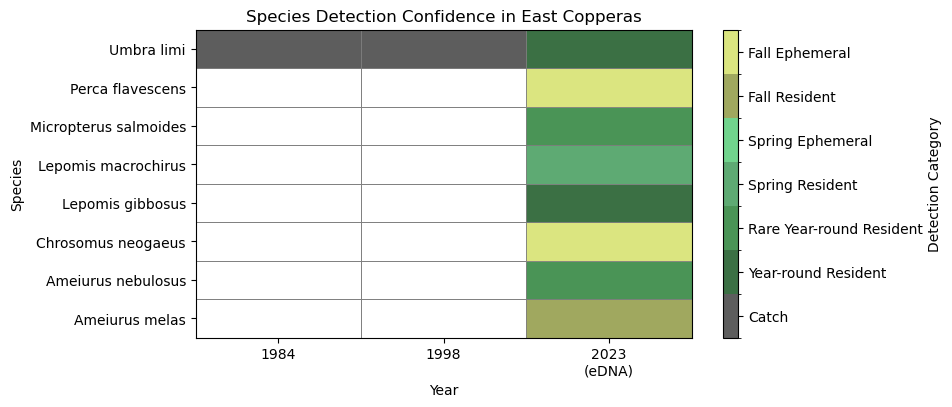

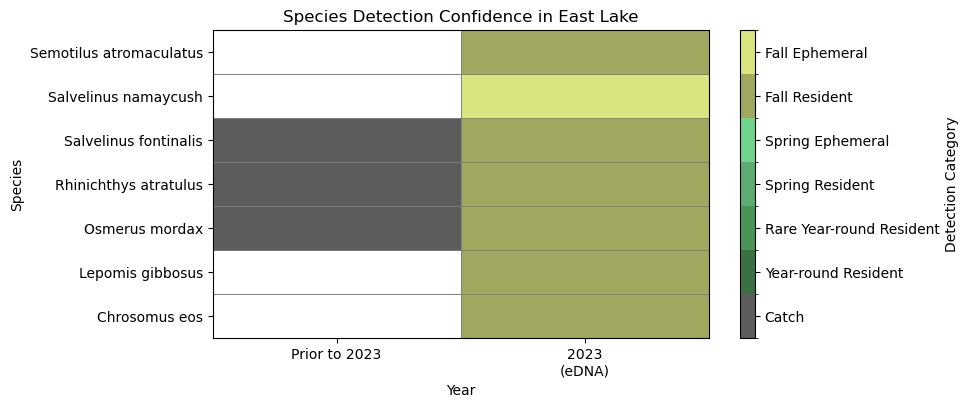

In [33]:
for lake_name in df.Name.unique():
    # Now create a pivot table: species as rows, years as columns, values as confidence category numbers
    lake_df = df[df['Name'] == lake_name].sort_values(["Species", "confidence_num"], ascending = [False, True]).reset_index(drop=True)

    pivot = lake_df.pivot(index='Species', columns='Year', values='confidence_num')

    # Create a color palette for the confidence levels
    colors = ['#4B4B4B',  # Dark grey
              '#25602f',  # Dark summery green
              '#368944', # light
              '#4ca164',  # dark spring
              '#62d081',  # light spring
              '#969f4d',  # dark fall
              '#d7e372']  # light fall
    cmap = ListedColormap(colors)

    # Set normalization boundaries between each category
    bounds = np.arange(len(confidence_levels) + 1) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot
    plt.figure(figsize=(8, 4))
    heatmap = plt.pcolormesh(pivot.values, cmap=cmap, norm=norm, edgecolors='gray', 
                             linewidth=0.5, shading='auto', alpha = 0.9)

    # Set ticks and labels
    if lake_name in ['East Lake', 'Green Lake', 'Combs Lake', 'Little Moose Lake']:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=["Prior to 2023", "2023\n(eDNA)"])
    else:
        plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5, labels=pivot.columns.tolist()[0:-1] + ["2023\n(eDNA)"])
    plt.yticks(ticks=np.arange(len(pivot.index)) + 0.5, labels=pivot.index)
    plt.title(f'Species Detection Confidence in {lake_name}')
    plt.xlabel('Year')
    plt.ylabel('Species')

    # Add a colorbar with confidence levels
    cbar = plt.colorbar(heatmap, ticks=range(len(confidence_levels)))
    cbar.ax.set_yticklabels(confidence_levels)
    cbar.set_label('Detection Category')

    plt.savefig("../" + lake_name + "_change.pdf", dpi = 300)

In [88]:
modern = df[df["Reads"].notna()]

In [89]:
modern = modern.drop_duplicates(["Name", "Species"]).reset_index(drop=True).sort_values("Name").reset_index(drop=True)

In [91]:
old = df[df["Reads"].isna()][df["Year"] == 2006].reset_index(drop=True)

/fs/dss/scratch/7047893_noge4093_mpcs046/ipykernel_642965/2488974983.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  old = df[df["Reads"].isna()][df["Year"] == 2006].reset_index(drop=True)


In [92]:
old = old.drop_duplicates(["Name", "Species"]).reset_index(drop=True).sort_values("Name").reset_index(drop=True)

In [104]:
alltimes = df[df["Year"] > 2005].drop_duplicates(["Name", "Species"]).reset_index(drop=True).sort_values("Name").reset_index(drop=True)

In [119]:
alltimes["Detection"] = np.nan
for i in range(len(alltimes)):
    tmp1 = modern[modern["Name"] == alltimes["Name"][i]][modern["Species"] == alltimes["Species"][i]].reset_index(drop=True)
    tmp2 = old[old["Name"] == alltimes["Name"][i]][old["Species"] == alltimes["Species"][i]].reset_index(drop=True)
    if ((len(tmp1) > 0) and (len(tmp2) > 0)):
        alltimes["Detection"][i] = "Detected by both catch and eDNA"
    elif ((len(tmp2) == 0) and (len(tmp1) > 0)):
        alltimes["Detection"][i] = "Detected only by eDNA"
    elif ((len(tmp1) == 0) and (len(tmp2) > 0)):
        alltimes["Detection"][i] = "Detected only by catch"

/fs/dss/scratch/7047893_noge4093_mpcs046/ipykernel_642965/2892855699.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp1 = modern[modern["Name"] == alltimes["Name"][i]][modern["Species"] == alltimes["Species"][i]].reset_index(drop=True)
/fs/dss/scratch/7047893_noge4093_mpcs046/ipykernel_642965/2892855699.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp2 = old[old["Name"] == alltimes["Name"][i]][old["Species"] == alltimes["Species"][i]].reset_index(drop=True)
/fs/dss/scratch/7047893_noge4093_mpcs046/ipykernel_642965/2892855699.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will be

/fs/dss/scratch/7047893_noge4093_mpcs046/ipykernel_642965/2945042179.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

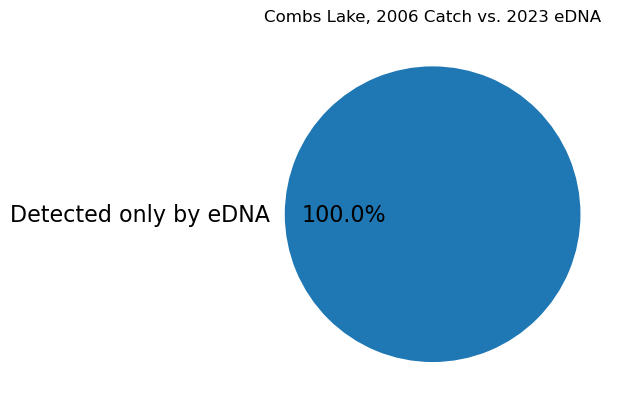

<Figure size 640x480 with 0 Axes>

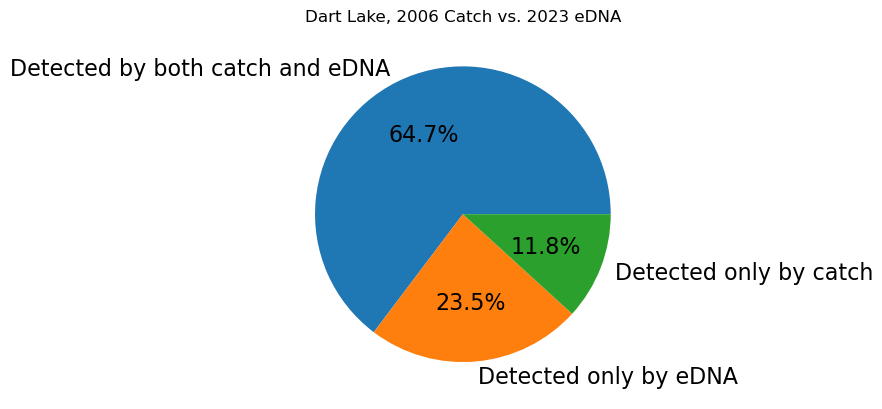

<Figure size 640x480 with 0 Axes>

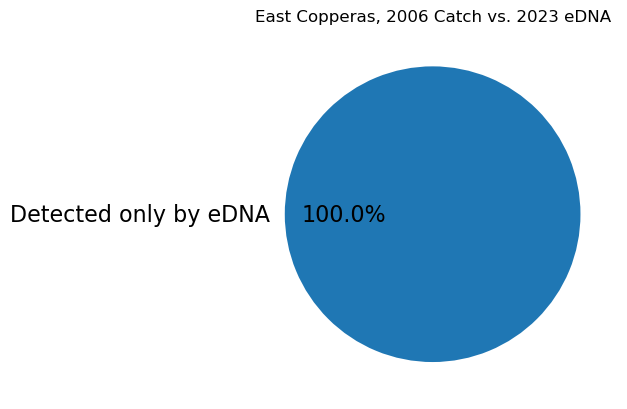

<Figure size 640x480 with 0 Axes>

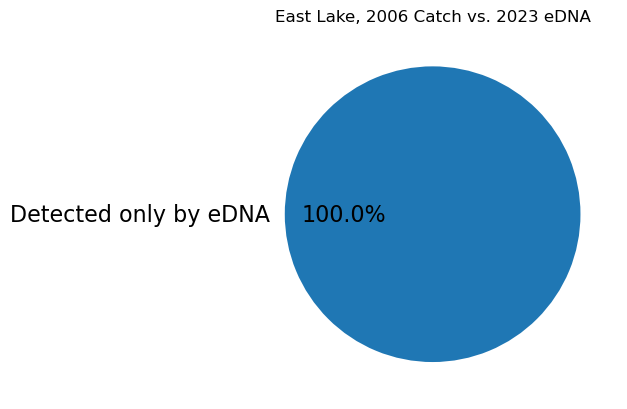

<Figure size 640x480 with 0 Axes>

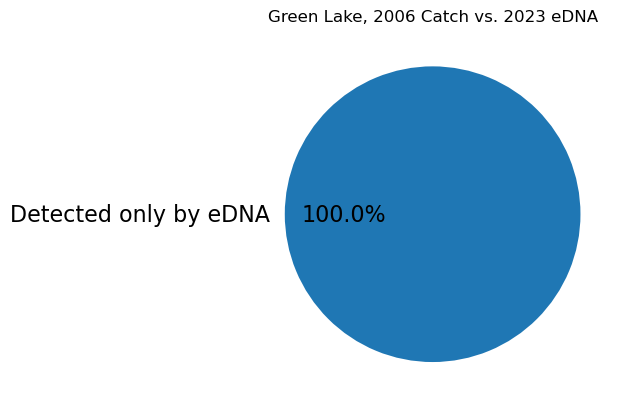

<Figure size 640x480 with 0 Axes>

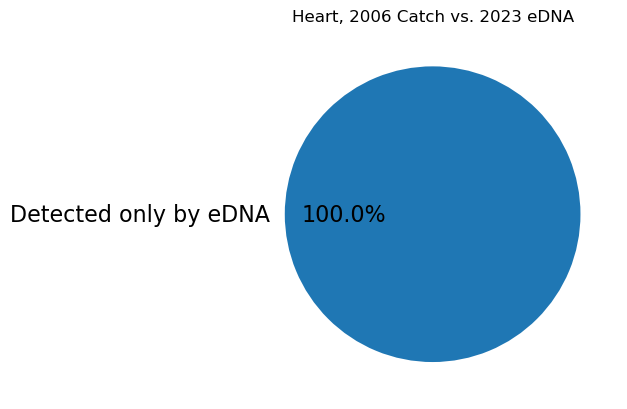

<Figure size 640x480 with 0 Axes>

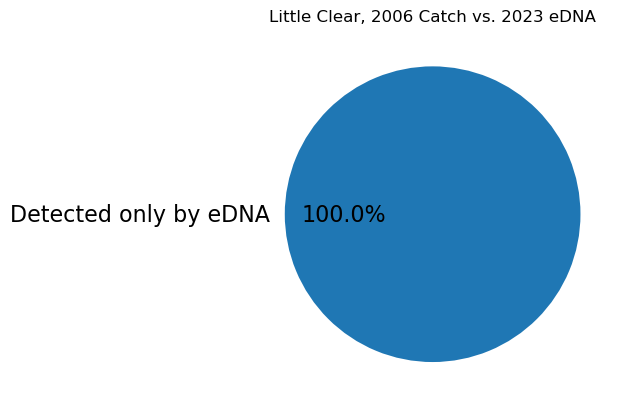

<Figure size 640x480 with 0 Axes>

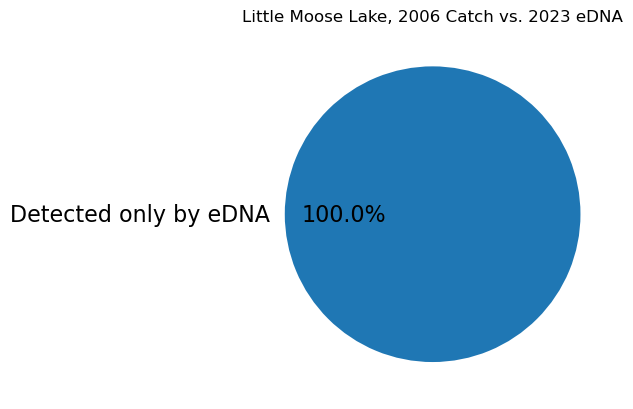

<Figure size 640x480 with 0 Axes>

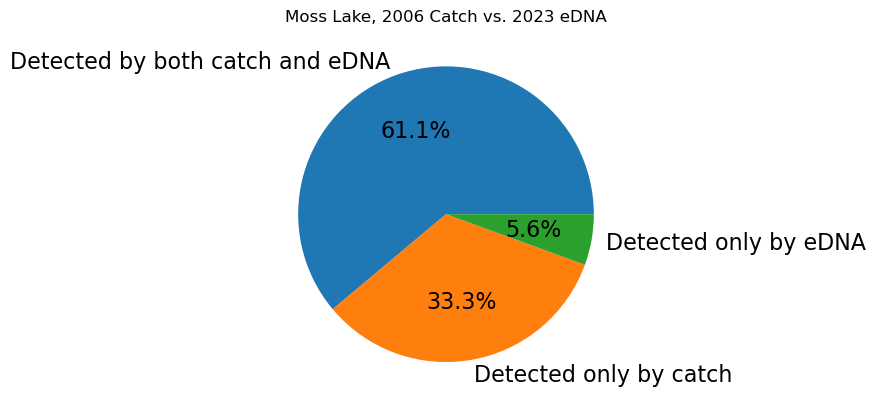

<Figure size 640x480 with 0 Axes>

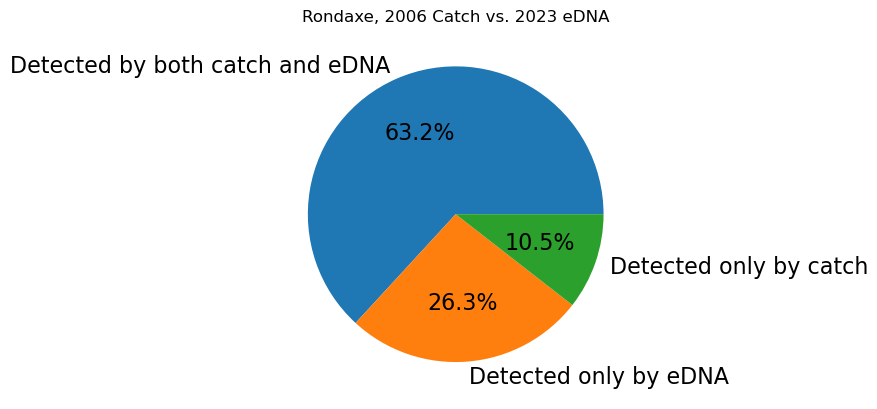

<Figure size 640x480 with 0 Axes>

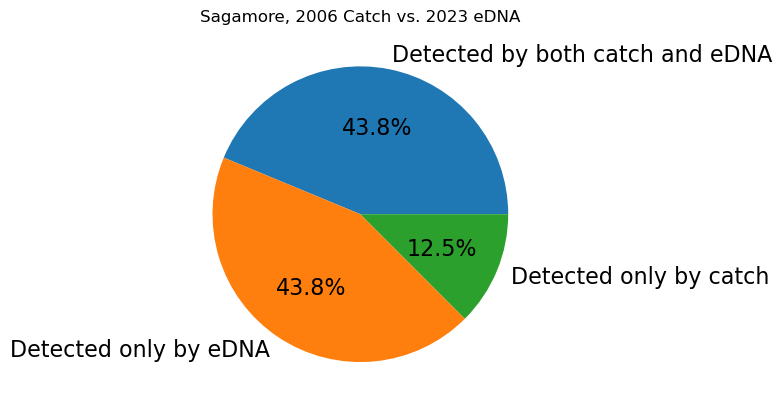

<Figure size 640x480 with 0 Axes>

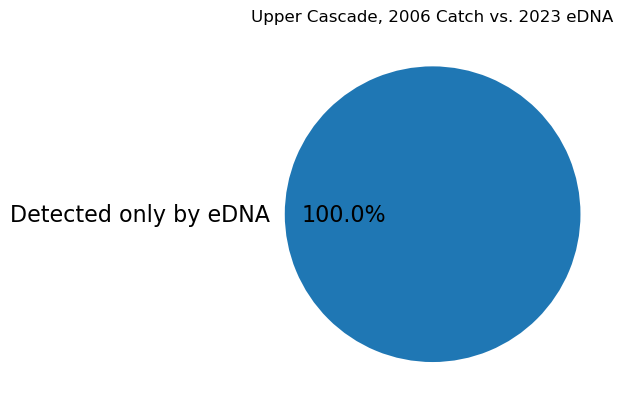

In [137]:
for i in alltimes.Name.unique().tolist():
    tmp = pd.DataFrame(alltimes[alltimes["Name"] == i].value_counts("Detection")).reset_index(drop=False)
    plt.figure()
    labels = tmp["Detection"].tolist()
    sizes = tmp["count"].tolist()
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 16})
    plt.title(i + ", 2006 Catch vs. 2023 eDNA")

In [344]:
lakemeta = size_migration.merge(pd.read_csv("../lake_metadata.csv"), how = "left", on = "Name")
lakemeta["Percentage Resident"] = lakemeta["Percentage Resident"].astype(float)

In [345]:
corrdata = lakemeta[["Name", 'Invert_Family_Richness', 'thermo_depth', "thermo_temp",
       'depth.5mgL', 'temp.5mgL', 'min_do', 'sechi.depth', 'Flushing Rate (times/yr)', 'Shoreline Length (km)',
       'Littoral Area (ha)', 'surface_area (ha)', "Percentage Resident"]].drop_duplicates(["Name"])

In [346]:
corrdata = corrdata[['Invert_Family_Richness', 'thermo_depth', "thermo_temp",
       'depth.5mgL', 'temp.5mgL', 'min_do', 'sechi.depth', 'Flushing Rate (times/yr)', 'Shoreline Length (km)',
       'Littoral Area (ha)', 'surface_area (ha)', "Percentage Resident"]]

In [347]:
corr = corrdata.corr()

Text(0.5, 1.0, 'Correlation Matrix - Lake characteristics and percentage of resident species')

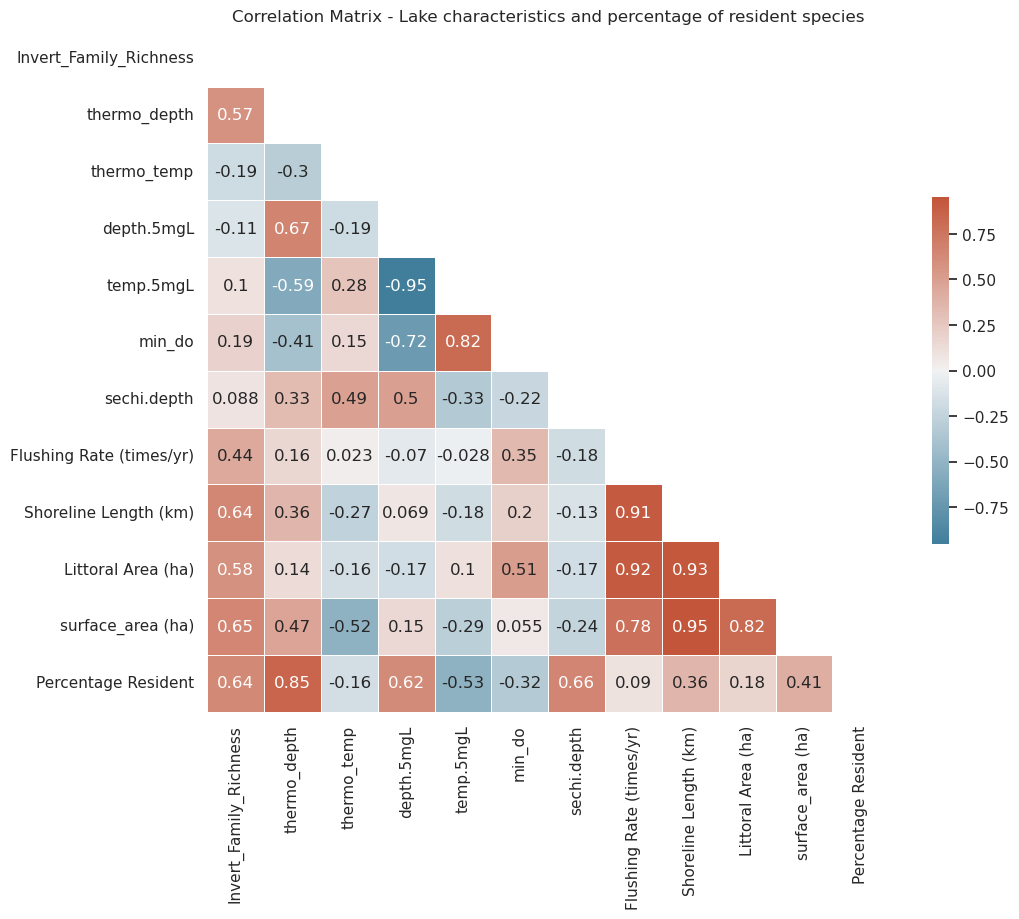

In [350]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlation Matrix - Lake characteristics and percentage of resident species")

In [15]:
subset[["Overall_Best"]].to_csv("../fishlist.txt", sep = "\t", index = False)

In [24]:
metadata.loc[metadata["Description"] == "Near Shore", "Description"] = "Nearshore"

In [95]:
species_habitat = pd.read_csv("../ALS_fishcodes_with_latin_names.csv")
species_habitat.loc[species_habitat["Latin Name"].str.contains("Coregonus"), "Latin Name"] = "Coregonus"
species_habitat = species_habitat[species_habitat["habitat"].notna()].reset_index(drop=True)

In [145]:
offshore = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (joined[metadata["EGCF-ID"]
                  [metadata["Name"] == lake][metadata["Description"].isin(["Deep", "Surface"])]
                  [metadata["Season"] == season].tolist() + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [joined["Primer"] == "MiFish"]).fillna(0).reset_index(drop=True)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
        tmp1 = tmp[tmp["Overall_Best"] == i]
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
            tmp2 = tmp[tmp["Family"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
            tmp2 = tmp[tmp["Genus"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
    tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[1:-1]]
    tmp = tmp[[sp for sp in species_habitat["Latin Name"][species_habitat["habitat"].str.contains("offshore")].tolist() if sp in tmp.columns.tolist()]]
    shuffles = []
    try:
        for shuff in list(range(0,1000)):
            tmp1 = tmp.copy()
            for tax in tmp.columns:
                tmp1[tax] = np.random.permutation(tmp[tax].values)
            for nsamps in list(range(1, len(tmp) + 1)):
                shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
        shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
        shuffles["Name"] = lake
        shuffles["Season"] = season
        offshore = pd.concat([offshore, shuffles]).reset_index(drop=True)
    except:
        pass

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1604534734.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1604534734.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1604534734.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

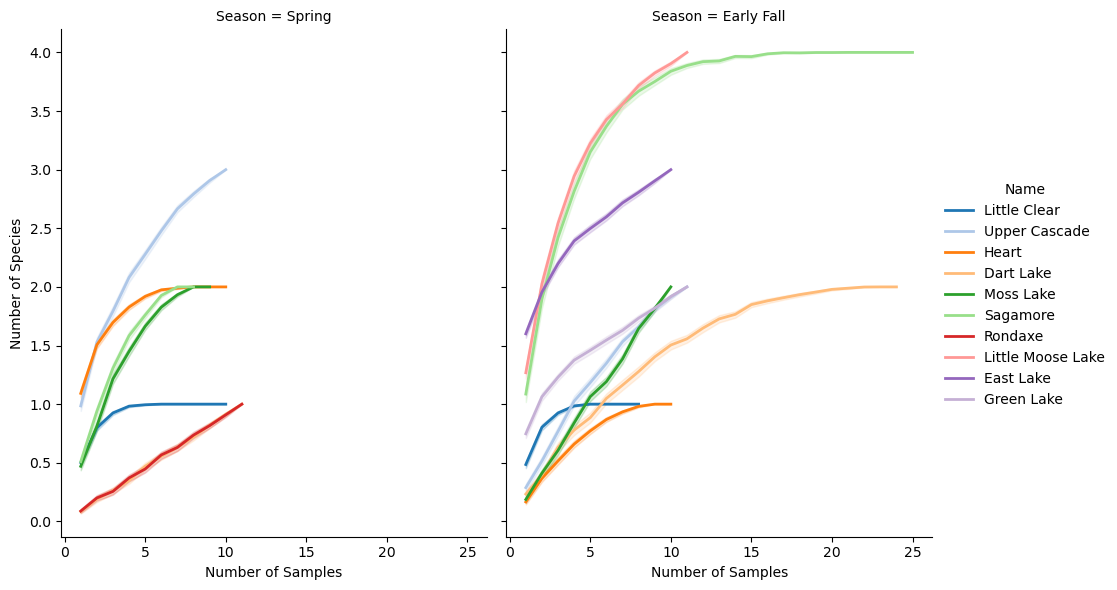

In [112]:
g = sns.FacetGrid(offshore.reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()

In [88]:
deep = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (joined[metadata["EGCF-ID"]
                  [metadata["Name"] == lake][metadata["Description"] == "Deep"]
                  [metadata["Season"] == season].tolist() + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [joined["Primer"] == "MiFish"]).fillna(0).reset_index(drop=True)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
        tmp1 = tmp[tmp["Overall_Best"] == i]
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
            tmp2 = tmp[tmp["Family"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
            tmp2 = tmp[tmp["Genus"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
    tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[1:-1]]
    tmp = tmp[[sp for sp in species_habitat["Latin Name"][species_habitat["habitat"] == "offshore deep"].tolist() if sp in tmp.columns.tolist()]]
    shuffles = []
    try:
        for shuff in list(range(0,1000)):
            tmp1 = tmp.copy()
            for tax in tmp.columns:
                tmp1[tax] = np.random.permutation(tmp[tax].values)
            for nsamps in list(range(1, len(tmp) + 1)):
                shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
        shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
        shuffles["Name"] = lake
        shuffles["Season"] = season
        deep = pd.concat([deep, shuffles]).reset_index(drop=True)
    except:
        pass

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3721076481.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3721076481.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3721076481.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

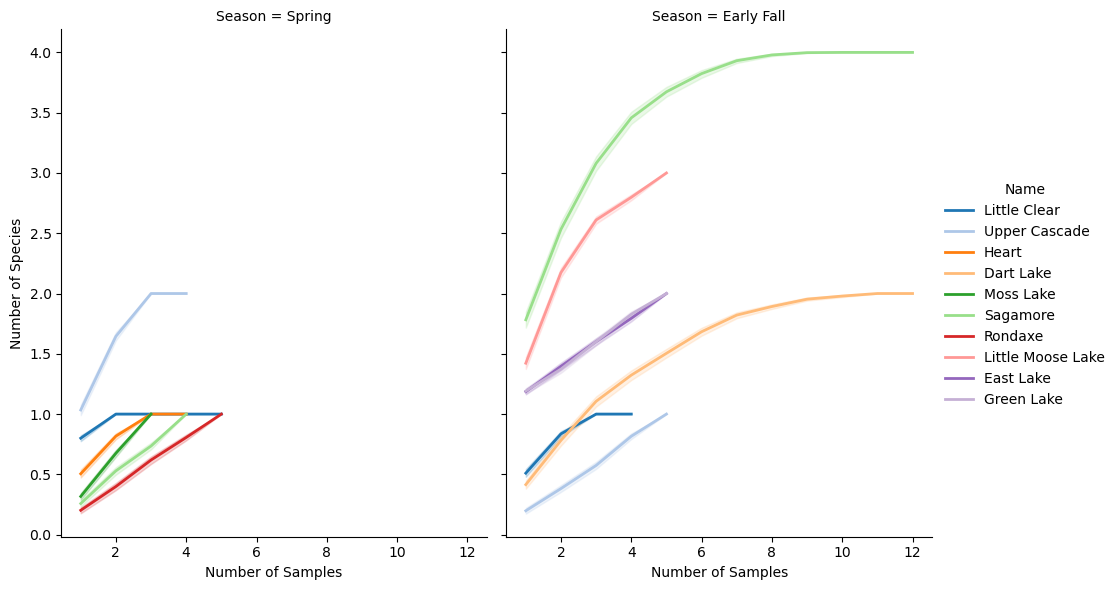

In [89]:
g = sns.FacetGrid(deep.reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()

In [199]:
nearshore = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (joined[metadata["EGCF-ID"]
                  [metadata["Name"] == lake][metadata["Description"] == "Nearshore"]
                  [metadata["Season"] == season].tolist() + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [joined["Primer"] == "MiFish"]).fillna(0).reset_index(drop=True)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
        tmp1 = tmp[tmp["Overall_Best"] == i]
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
            tmp2 = tmp[tmp["Family"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
            tmp2 = tmp[tmp["Genus"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
    tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[1:-1]]
    tmp = tmp[[sp for sp in species_habitat["Latin Name"][species_habitat["habitat"] == "nearshore"].tolist() if sp in tmp.columns.tolist()]]
    shuffles = []
    try:
        for shuff in list(range(0,1000)):
            tmp1 = tmp.copy()
            for tax in tmp.columns:
                tmp1[tax] = np.random.permutation(tmp[tax].values)
            for nsamps in list(range(1, len(tmp) + 1)):
                shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
        shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
        shuffles["Name"] = lake
        shuffles["Season"] = season
        nearshore = pd.concat([nearshore, shuffles]).reset_index(drop=True)
    except:
        pass

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1579055145.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1579055145.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1579055145.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

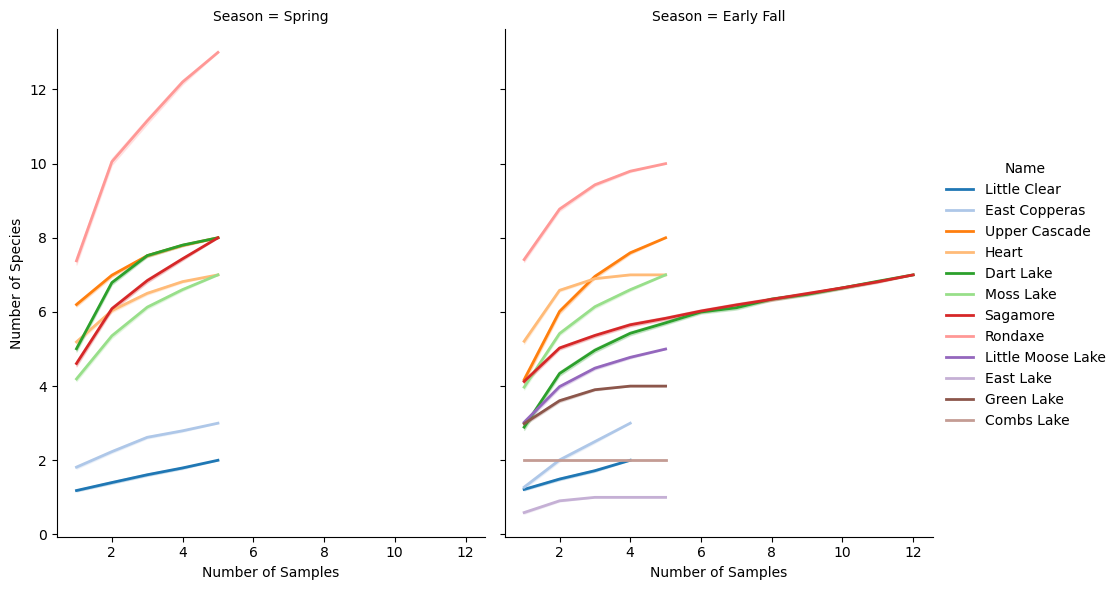

In [85]:
g = sns.FacetGrid(nearshore.reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()

In [132]:
# Function to calculate RSS
def calculate_rss(y_data, y_model):
    return np.sum((y_data - y_model) ** 2)

# 1. Michaelis-Menten model (Basic)
def michaelis_menten(x, K, C, B):
    return (K * x) / (x + C)

# 2. Hill function model
def hill_function(x, K, C, n):
    return (K * x**n) / (C**n + x**n)

# 3. Generalized Logistic model
def generalized_logistic(x, K, B, C):
    return K / (1 + np.exp(-B * (x - C)))

# 4. Logistic Growth (Standard S-shaped curve)
def logistic_growth(x, K, r, x0):
    return K / (1 + np.exp(-r * (x - x0)))

# 5. Richards Curve (generalized logistic curve)
def richards(x, K, r, x0, v):
    return K / (1 + np.exp(-r * (x - x0)))**(1/v)

# 6. Gompertz Curve (asymptotic curve)
def gompertz(x, K, r, x0):
    return K * np.exp(-np.exp(-r * (x - x0)))

# 7. Exponential Decay (Inverted)
def exp_decay(x, A, B, C):
    return A * np.exp(-B * (x - C))

# 8. Shifted Logistic Growth (shifted S-curve)
def shifted_logistic(x, K, r, x0):
    return K / (1 + np.exp(-r * (x - x0)))

# 9. Exponential Growth Model (inverse of decay)
def exp_growth(x, A, r, C):
    return A * np.exp(r * (x - C))

# 10. Monod Equation (a variant of Michaelis-Menten)
def monod(x, K, S, B):
    return (K * x) / (S + x)

# 11. Humboldt Growth Curve (another biological growth model)
def humboldt_growth(x, K, r, x0):
    return K / (1 + np.exp(-r * (x - x0)))

# 12. Barton Curve (used in environmental sciences)
def barton_curve(x, A, B, C):
    return A / (1 + np.exp(-B * (x - C)))

models = {
    "Michaelis-Menten": michaelis_menten,
    "Hill": hill_function,
    "Generalized Logistic": generalized_logistic,
    "Logistic Growth": logistic_growth,
    "Richards": richards,
    "Gompertz": gompertz,
    "Exponential Decay": exp_decay,
    "Shifted Logistic": shifted_logistic,
    "Exponential Growth": exp_growth,
    "Monod": monod,
    "Humboldt Growth": humboldt_growth,
    "Barton Curve": barton_curve
}

# Initial parameter guesses for each model
initial_guesses = {
    "Michaelis-Menten": [50, 10, 2],
    "Hill": [50, 20, 2],
    "Generalized Logistic": [50, 0.1, 20],
    "Logistic Growth": [50, 0.1, 20],
    "Richards": [50, 0.1, 20, 1],
    "Gompertz": [50, 0.1, 20],
    "Exponential Decay": [50, 0.1, 10],
    "Shifted Logistic": [50, 0.1, 20],
    "Exponential Growth": [50, 0.1, 10],
    "Monod": [50, 20, 0.1],
    "Humboldt Growth": [50, 0.1, 20],
    "Barton Curve": [50, 0.1, 20]
}

model_bounds = {
    "Michaelis-Menten": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Hill": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Generalized Logistic": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Logistic Growth": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Richards": ([0, -np.inf, -np.inf, -np.inf], [80, np.inf, np.inf, np.inf]),
    "Gompertz": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Exponential Decay": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Shifted Logistic": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Exponential Growth": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Monod": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Humboldt Growth": ([0, -np.inf, -np.inf], [80, np.inf, np.inf]),
    "Barton Curve": ([0, -np.inf, -np.inf], [80, np.inf, np.inf])
}

In [169]:
offshore["Merged"] = offshore["Name"] + "_" + offshore["Season"]

In [170]:
lakes = offshore["Merged"].unique().tolist()

In [176]:
offshore = offshore.drop('Merged', axis=1) # Returns a new DataFrame

In [178]:
best_models_by_lake = {}
fitted_data = pd.DataFrame()
for lake in lakes:
    # Store results
    best_rss = np.inf
    best_curve = None
    best_params = None
    best_y_fit = None
    
    rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
           [offshore["Season"] == lake.split("_")[1]])
    rawdata = rawdata.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()
    x_data = np.append([0], np.array(rawdata["Number of Samples"]))
    y_data = np.append([0], np.array(rawdata["Number of Species"]))

    # Try fitting each curve type
    for curve_name in list(models.keys()):
        try:
            # Fit the curve
            popt, _ = curve_fit(models[curve_name], x_data, y_data, 
                                p0=initial_guesses[curve_name], 
                                bounds=model_bounds[curve_name],
                                maxfev=50000)

            # Calculate the fitted values
            y_fit = models[curve_name](x_data, *popt)

            # Calculate RSS
            rss = calculate_rss(y_data, y_fit)

            # Store the best model
            if rss < best_rss:
                best_rss = rss
                best_curve = curve_name
                best_params = popt
                best_y_fit = y_fit

            #print(f"Curve: {curve_name}, RSS: {rss}")

        except Exception as e:
            print(f"Error fitting {curve_name}: {e}")

    x_fit = np.linspace(min(x_data), max(x_data) + 1000, 1000)
    y_fit = models[best_curve](x_fit, *best_params)

    # Output best model and parameters
    print(f"\nBest curve: {best_curve}")
    print(f"Best parameters: {best_params}")
    print(f"Best RSS: {best_rss}")
    
    best_models_by_lake[lake] = [best_curve, best_params, best_rss]
    tmp = pd.DataFrame()
    tmp["Number of Samples"] = x_fit
    tmp["Number of Species"] = y_fit
    tmp["Name"] = lake.split("_")[0]
    tmp["Season"] = lake.split("_")[1]
    fitted_data = pd.concat([fitted_data, tmp]).reset_index(drop=True)

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.02699693 1.0032123  1.87335483]
Best RSS: 0.00188838547417761

Best curve: Hill
Best parameters: [1.02862401 1.01252281 2.02188329]
Best RSS: 0.001187415702728342

Best curve: Hill
Best parameters: [6.0071511  9.96223624 0.69359038]
Best RSS: 0.002013871144214278


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 3.89174981 10.35108212  1.11731867]
Best RSS: 0.003037099265376231

Best curve: Hill
Best parameters: [2.12362727 1.02002198 1.3362135 ]
Best RSS: 0.0029102270256141883


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.31191143 3.78075223 1.34211871]
Best RSS: 0.004714521784396331


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 80.         927.84012582   0.98597651]
Best RSS: 0.0011850288782771336

Best curve: Hill
Best parameters: [2.50028334 7.41885458 1.31890995]
Best RSS: 0.024648063050099218


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [2.49852974 3.11064364 1.45013407]
Best RSS: 0.01040341522643794

Best curve: Hill
Best parameters: [ 25.339246   101.45382561   1.06265791]
Best RSS: 0.009147837326242247


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [4.18118393 2.3337005  1.51368127]
Best RSS: 0.06952887594654653

Best curve: Hill
Best parameters: [2.50718537 2.77212628 1.44216973]
Best RSS: 0.01133681639642916


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 80.         916.88737069   0.99047694]
Best RSS: 0.0018638793195889954

Best curve: Hill
Best parameters: [5.14599776 3.07854383 0.98982658]
Best RSS: 0.004125104966314196


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.26560893e+01 3.61929091e+02 3.27912382e-01]
Best RSS: 0.0036506907040023727

Best curve: Hill
Best parameters: [ 5.97746044 47.22356237  0.49388968]
Best RSS: 0.011690055089350641


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/4169208709.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (offshore[offshore["Name"] == lake.split("_")[0]]


In [179]:
fitted_data.to_csv("../fitted_data_offshore.csv", index = False)

In [180]:
best_models = pd.DataFrame(best_models_by_lake).T.reset_index(drop=False)
best_models.columns = ["Lake", "Function", "Parameters", "RSS"]

In [181]:
best_models.to_csv("../fitted_curves_offshore.csv", index = False)

In [182]:
plotting_accumulation = offshore.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()

In [223]:
all_lakes = offshore.Name.unique().tolist()

In [186]:
ninety_offshore = pd.DataFrame()
for i in all_lakes:
    for season in ["Early Fall", "Spring"]:
        try:
            if best_models_by_lake[i + "_" + season][0] in ["Hill",'Michaelis-Menten']:
                tmp = (fitted_data
                 [fitted_data["Name"] == i]
                 [fitted_data["Season"] == season]
                 [fitted_data["Number of Species"] > (best_models_by_lake[i + "_" + season][1][0] * 0.9)]
                 .reset_index(drop=True).head(1))
                ninety_offshore = pd.concat([ninety_offshore, tmp]).reset_index(drop=True)
        except:
            pass

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1843792847.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1843792847.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1843792847.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1843792847.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1843792847.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/1843792847.py:6: UserWarning: Boolean Series key will be reindexed to match 

In [200]:
nearshore["Merged"] = nearshore["Name"] + "_" + nearshore["Season"]

In [ ]:
lakes = nearshore["Merged"].unique().tolist()

In [202]:
nearshore = nearshore.drop('Merged', axis=1) # Returns a new DataFrame

In [203]:
best_models_by_lake = {}
fitted_data = pd.DataFrame()
for lake in lakes:
    # Store results
    best_rss = np.inf
    best_curve = None
    best_params = None
    best_y_fit = None
    
    rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
           [nearshore["Season"] == lake.split("_")[1]])
    rawdata = rawdata.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()
    x_data = np.append([0], np.array(rawdata["Number of Samples"]))
    y_data = np.append([0], np.array(rawdata["Number of Species"]))

    # Try fitting each curve type
    for curve_name in list(models.keys()):
        try:
            # Fit the curve
            popt, _ = curve_fit(models[curve_name], x_data, y_data, 
                                p0=initial_guesses[curve_name], 
                                bounds=model_bounds[curve_name],
                                maxfev=50000)

            # Calculate the fitted values
            y_fit = models[curve_name](x_data, *popt)

            # Calculate RSS
            rss = calculate_rss(y_data, y_fit)

            # Store the best model
            if rss < best_rss:
                best_rss = rss
                best_curve = curve_name
                best_params = popt
                best_y_fit = y_fit

            #print(f"Curve: {curve_name}, RSS: {rss}")

        except Exception as e:
            print(f"Error fitting {curve_name}: {e}")

    x_fit = np.linspace(min(x_data), max(x_data) + 1000, 1000)
    y_fit = models[best_curve](x_fit, *best_params)

    # Output best model and parameters
    print(f"\nBest curve: {best_curve}")
    print(f"Best parameters: {best_params}")
    print(f"Best RSS: {best_rss}")
    
    best_models_by_lake[lake] = [best_curve, best_params, best_rss]
    tmp = pd.DataFrame()
    tmp["Number of Samples"] = x_fit
    tmp["Number of Species"] = y_fit
    tmp["Name"] = lake.split("_")[0]
    tmp["Season"] = lake.split("_")[1]
    fitted_data = pd.concat([fitted_data, tmp]).reset_index(drop=True)

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [7.99999997e+01 2.28498199e+05 3.43810165e-01]
Best RSS: 0.008412254812929442

Best curve: Hill
Best parameters: [8.00000000e+01 1.40388595e+05 3.51990514e-01]
Best RSS: 0.004603972523082684


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [5.79278703 4.40943934 0.53967185]
Best RSS: 0.00032294980423408693

Best curve: Hill
Best parameters: [ 9.46215318 10.81310043  0.77708209]
Best RSS: 0.0016065960313192476


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.p


Best curve: Hill
Best parameters: [10.86177173  0.53380355  0.46235847]
Best RSS: 0.001313903127757314

Best curve: Hill
Best parameters: [9.8849924  1.34433946 1.10282861]
Best RSS: 8.985331640963453e-05


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.p


Best curve: Hill
Best parameters: [10.9898638   1.29445351  0.42433542]
Best RSS: 0.0043300362410525544

Best curve: Hill
Best parameters: [7.05282591 0.68385878 2.62877221]
Best RSS: 0.00048531935375763235

Best curve: Hill
Best parameters: [8.44950619 0.81428962 1.58001154]
Best RSS: 0.00037403625042154397


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [8.36320471 1.98733494 0.85003169]
Best RSS: 0.06870172055548408

Best curve: Hill
Best parameters: [12.42539948  3.22549503  0.57441221]
Best RSS: 0.0004000466116008692


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.p


Best curve: Hill
Best parameters: [9.21054206 1.35931651 0.87183361]
Best RSS: 0.0035715309515763328

Best curve: Hill
Best parameters: [16.38759847 34.20469033  0.30227037]
Best RSS: 0.07698822139947525


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.p


Best curve: Hill
Best parameters: [12.3268741   2.14448167  0.70329711]
Best RSS: 0.015699949780829257

Best curve: Hill
Best parameters: [19.68095175  1.97020419  0.7038847 ]
Best RSS: 0.01844309481481158


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.p


Best curve: Hill
Best parameters: [12.01502197  0.49880055  0.70446998]
Best RSS: 0.0048977854382898

Best curve: Hill
Best parameters: [6.03766958 1.03177475 0.99423577]
Best RSS: 0.0010710801497226788


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [1.02420242 0.84901893 2.43119442]
Best RSS: 0.0006850634343581526

Best curve: Hill
Best parameters: [4.19664094 0.54176336 1.44144451]
Best RSS: 0.0035108975970443183


/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2934834110.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (nearshore[nearshore["Name"] == lake.split("_")[0]]
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/3696820392.p


Best curve: Generalized Logistic
Best parameters: [ 2.         48.72821014  0.49616347]
Best RSS: 5.893475923775439e-21


In [204]:
fitted_data.to_csv("../fitted_data_nearshore.csv", index = False)

In [205]:
best_models = pd.DataFrame(best_models_by_lake).T.reset_index(drop=False)
best_models.columns = ["Lake", "Function", "Parameters", "RSS"]

In [206]:
best_models.to_csv("../fitted_curves_nearshore.csv", index = False)

In [207]:
plotting_accumulation = offshore.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()

In [208]:
all_lakes = offshore.Name.unique().tolist()

In [209]:
ninety_nearshore = pd.DataFrame()
for i in all_lakes:
    for season in ["Early Fall", "Spring"]:
        try:
            if best_models_by_lake[i + "_" + season][0] in ["Hill",'Michaelis-Menten']:
                tmp = (fitted_data
                 [fitted_data["Name"] == i]
                 [fitted_data["Season"] == season]
                 [fitted_data["Number of Species"] > (best_models_by_lake[i + "_" + season][1][0] * 0.9)]
                 .reset_index(drop=True).head(1))
                ninety_nearshore = pd.concat([ninety_nearshore, tmp]).reset_index(drop=True)
        except:
            pass

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2940898625.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2940898625.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2940898625.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2940898625.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2940898625.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/2940898625.py:6: UserWarning: Boolean Series key will be reindexed to match 

In [216]:
comparison = ninety_nearshore.merge(ninety_offshore, how = "inner", on = ["Name", "Season"])

In [222]:
np.mean(comparison["Number of Samples_y"] - comparison["Number of Samples_x"])

75.8429540651763

Because this number is positive, this means that deep samples are more likely to be slow to accumulate, and therefore deep regions require more intense sampling effort.

Let's see if nearshore species are more likely to be found in deep samples than deep species in nearshore species:

In [229]:
lakes = [i for i in metadata["Merged"][metadata["Merged"].notna()].unique().tolist() if "Blank" not in i]

In [325]:
overlapsummary = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (joined[metadata["EGCF-ID"]
                  [metadata["Name"] == lake]
                  [metadata["Season"] == season].tolist() + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [joined["Primer"] == "MiFish"]).fillna(0)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
        tmp1 = tmp[tmp["Overall_Best"] == i]
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
            tmp2 = tmp[tmp["Family"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
            tmp2 = tmp[tmp["Genus"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
    tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    allnearshorespp = [spp for spp in tmp.columns.tolist() if spp in species_habitat["Latin Name"][species_habitat["habitat"] == "nearshore"].tolist()]
    alldeepspp = [spp for spp in tmp.columns.tolist() if spp in species_habitat["Latin Name"][species_habitat["habitat"].str.contains("offshore deep")].tolist()]
    deep = (tmp[tmp["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake][metadata["Season"] == season]
                       [metadata["Description"].isin(["Deep"])].tolist())])
    deep = deep.loc[:, (deep != 0).any(axis=0)]
    deep = deep[deep.columns[1:-1]]
    shallow = (tmp[tmp["index"].isin(metadata["EGCF-ID"][metadata["Name"] == lake][metadata["Season"] == season]
                       [metadata["Description"].isin(["Nearshore"])].tolist())])
    shallow = shallow.loc[:, (shallow != 0).any(axis=0)]
    shallow = shallow[shallow.columns[1:-1]]
    nshallowindeep = np.mean(deep[[spp for spp in deep.columns.tolist() if spp in allnearshorespp]].astype(bool).sum(axis=1)) / len(allnearshorespp)
    ndeepinshallow = np.mean(shallow[[spp for spp in shallow.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp) 
    ndeepindeep = np.mean(deep[[spp for spp in deep.columns.tolist() if spp in alldeepspp]].astype(bool).sum(axis=1)) / len(alldeepspp)
    nshallowinshallow = np.mean(shallow[[spp for spp in shallow.columns.tolist() if spp in allnearshorespp]].astype(bool).sum(axis=1)) / len(allnearshorespp) 
    tmp1 = pd.DataFrame(data = [nshallowinshallow, nshallowindeep, ndeepindeep, ndeepinshallow, merge]).T
    tmp1.columns = ["Proportion of nearshore species in nearshore samples", "Proportion of nearshore species in deep samples", 
                              "Proportion of deep species in deep samples", "Proportion of deep species in nearshore samples", 
                              "Lake x Season"]
    overlapsummary = pd.concat([overlapsummary, tmp1]).reset_index(drop=True)

/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/141703269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/141703269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
/fs/dss/scratch/7695796_noge4093_mpcs046/ipykernel_3149062/141703269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [326]:
print(overlapsummary["Proportion of nearshore species in deep samples"].mean())
print(overlapsummary["Proportion of deep species in nearshore samples"].mean())

0.3868564213564213
0.18


In [329]:
overlapsummary

Proportion of nearshore species in nearshore samples  \
0                                                 0.4     
1                                               0.625     
2                                                0.36     
3                                            0.208333     
4                                            0.577778     
5                                                 0.4     
6                                                0.65     
7                                                0.65     
8                                            0.454545     
9                                            0.291667     
10                                              0.525     
11                                                0.5     
12                                           0.371212     
13                                              0.575     
14                                               0.48     
15                                               0.74     
16                                           0.428571     
17                                               0.15     
18                                                0.6     
19                                                1.0     

   Proportion of nearshore species in deep samples  \
0                                              0.4   
1                                            0.625   
2                                              0.2   
3                                             0.25   
4                                         0.194444   
5                                         0.266667   
6                                           0.3125   
7                                            0.375   
8                                         0.290909   
9                                         0.208333   
10                                        0.291667   
11                                           0.375   
12                                        0.189394   
13                                          0.3125   
14                                             0.4   
15                                             0.6   
16                                        0.285714   
17                                             0.6   
18                                            0.56   
19                                             1.0   

   Proportion of deep species in deep samples  \
0                                         0.8   
1                                         0.5   
2                                         NaN   
3                                         NaN   
4                                         0.5   
5                                         0.1   
6                                         0.5   
7                                         NaN   
8                                         0.0   
9                                    0.208333   
10                                   0.333333   
11                                        0.0   
12                                   0.472222   
13                                      0.125   
14                                        0.2   
15                                        NaN   
16                                   0.466667   
17                                        0.6   
18                                        0.6   
19                                        NaN   

   Proportion of deep species in nearshore samples  \
0                                              0.2   
1                                             0.25   
2                                              NaN   
3                                              NaN   
4                                              0.4   
5                                              0.1   
6                                              0.2   
7                                              NaN   
8                                              0.0   
9                                              0.0   
10  

In [327]:
print(overlapsummary["Proportion of nearshore species in nearshore samples"].mean())
print(overlapsummary["Proportion of deep species in deep samples"].mean())

0.4993553391053391
0.3603703703703704


This indicates that more nearshore species bleed into offshore samples than do offshore species into nearshore samples (in an average lake, 42.1% of the nearshore species are also detected by deep samples, compared with 22.7% of offshore species also being detected by nearshore samples). This, taken in combination with the lower accumulation rate of offshore species (probably spotty distributions and small populations), indicates we may need to actually take more integrated (shallow + deep) offshore samples than we do nearshore samples.

In [ ]:
accumulation_curves = pd.DataFrame()
for merge in metadata["Merged"][~metadata["Site"].isin(["PCR Blank", "Blank", "Extraction Blank"])][metadata["Merged"].notna()].unique().tolist():
    lake = merge.split("_")[0]
    season = merge.split("_")[1]
    tmp = (joined[metadata["EGCF-ID"]
                  [metadata["Name"] == lake]
                  [metadata["Season"] == season].tolist() + 
                  ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
           [joined["Primer"] == "MiFish"]).fillna(0).reset_index(drop=True)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
    for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
        tmp1 = tmp[tmp["Overall_Best"] == i]
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
            tmp2 = tmp[tmp["Family"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
        if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
            tmp2 = tmp[tmp["Genus"] == i]
            for col in tmp2.columns[:-5].tolist():
                tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
            tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
            if len(tmp2) == 2:
                sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
                tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
    tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
    tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
    tmp = tmp[tmp["sum"] > lowcov]
    tmp = tmp[tmp.columns[1:-1]]
    shuffles = []
    for shuff in list(range(0,1000)):
        tmp1 = tmp.copy()
        for tax in tmp.columns:
            tmp1[tax] = np.random.permutation(tmp[tax].values)
        for nsamps in list(range(1, len(tmp))):
            shuffles = shuffles + [[tmp1.sample(nsamps).agg({'sum'}).astype(bool).sum(axis=1).reset_index(drop=True)[0], nsamps]]
    shuffles = pd.DataFrame(shuffles, columns = ["Number of Species", "Number of Samples"])
    shuffles["Name"] = lake
    shuffles["Season"] = season
    accumulation_curves = pd.concat([accumulation_curves, shuffles]).reset_index(drop=True)

In [ ]:
accumulation_curves.to_csv("../accumulation_curves.csv", index = False)

In [15]:
accumulation_curves = pd.read_csv("../accumulation_curves.csv")

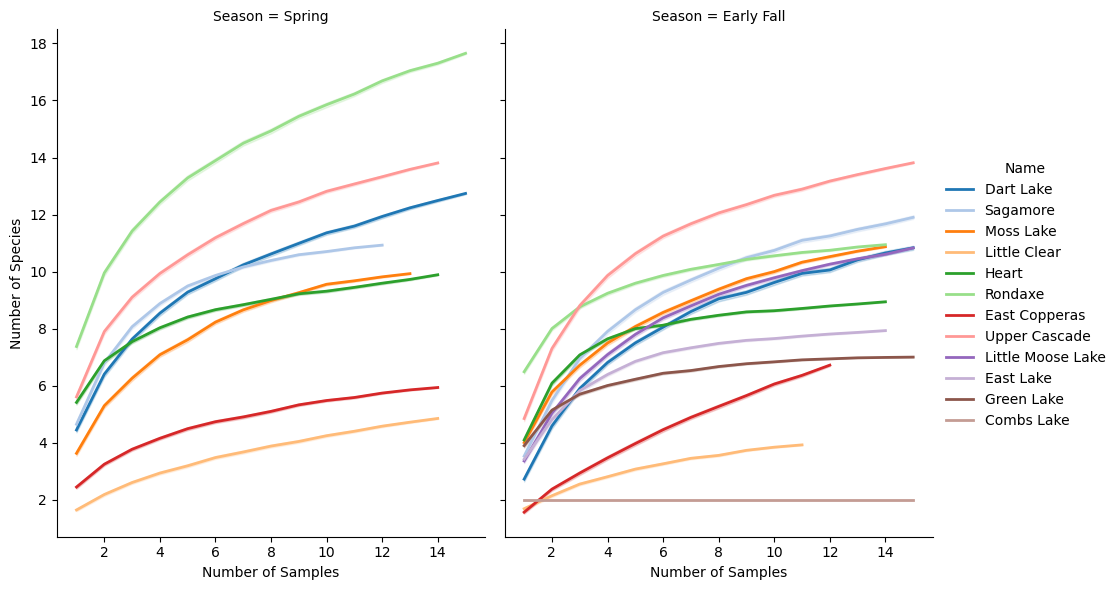

In [17]:
g = sns.FacetGrid(accumulation_curves[accumulation_curves["Number of Samples"] <= 15].reset_index(drop=True),
                  col="Season", hue = "Name", palette = "tab20", height=6, aspect=0.8)

# Map a scatterplot to the grid
g.map_dataframe(sns.lineplot, x = "Number of Samples", y = "Number of Species", lw = 2)
g.add_legend()
plt.savefig("../accumulation_plot_15samps.pdf", dpi = 300, bbox_inches='tight')

In [63]:
best_models_by_lake = {}
fitted_data = pd.DataFrame()
for lake in lakes:
    # Store results
    best_rss = np.inf
    best_curve = None
    best_params = None
    best_y_fit = None
    
    rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
           [accumulation_curves["Season"] == lake.split("_")[1]])
    rawdata = rawdata.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()
    x_data = np.append([0], np.array(rawdata["Number of Samples"]))
    y_data = np.append([0], np.array(rawdata["Number of Species"]))

    # Try fitting each curve type
    for curve_name in list(models.keys()):
        try:
            # Fit the curve
            popt, _ = curve_fit(models[curve_name], x_data, y_data, 
                                p0=initial_guesses[curve_name], 
                                bounds=model_bounds[curve_name],
                                maxfev=50000)

            # Calculate the fitted values
            y_fit = models[curve_name](x_data, *popt)

            # Calculate RSS
            rss = calculate_rss(y_data, y_fit)

            # Store the best model
            if rss < best_rss:
                best_rss = rss
                best_curve = curve_name
                best_params = popt
                best_y_fit = y_fit

            #print(f"Curve: {curve_name}, RSS: {rss}")

        except Exception as e:
            print(f"Error fitting {curve_name}: {e}")

    x_fit = np.linspace(min(x_data), max(x_data) + 1000, 1000)
    y_fit = models[best_curve](x_fit, *best_params)

    # Output best model and parameters
    print(f"\nBest curve: {best_curve}")
    print(f"Best parameters: {best_params}")
    print(f"Best RSS: {best_rss}")
    
    best_models_by_lake[lake] = [best_curve, best_params, best_rss]
    tmp = pd.DataFrame()
    tmp["Number of Samples"] = x_fit
    tmp["Number of Species"] = y_fit
    tmp["Name"] = lake.split("_")[0]
    tmp["Season"] = lake.split("_")[1]
    fitted_data = pd.concat([fitted_data, tmp]).reset_index(drop=True)

/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [5.33013578e+01 2.74993738e+03 4.35784157e-01]
Best RSS: 0.002130751406382282


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [10.54138798 31.48338767  0.48724341]
Best RSS: 0.005812749615545431


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [10.51690024  8.69728931  0.5505833 ]
Best RSS: 0.005777028154251806


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [ 80.         549.41756782   0.6261264 ]
Best RSS: 0.012651042654158793


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [19.66531611  3.87078851  0.65721586]
Best RSS: 0.06517703330069557


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [16.6493059   2.66495517  0.88997939]
Best RSS: 0.04861473883585835


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [11.895724    1.28628585  0.64001396]
Best RSS: 0.037697454524391674


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [9.26470153 1.19744327 1.26176991]
Best RSS: 0.02060354034345285


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [19.22837787  5.71557801  0.67242341]
Best RSS: 0.07809927609905543


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [16.09140237  6.07555886  0.82565345]
Best RSS: 0.21417323439440494


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [13.53818385  3.52490933  0.80561659]
Best RSS: 0.05425383773788874


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [16.94009815  5.71534019  0.65823122]
Best RSS: 0.03352324627063996


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [16.38672256  4.50498876  0.81742146]
Best RSS: 0.19323161634953534


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [12.2370015   1.60215044  1.06863004]
Best RSS: 0.011465694112269645


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [29.62019386  7.48411878  0.53278698]
Best RSS: 0.1614205327106781


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [12.63370528  0.91291926  0.67826699]
Best RSS: 0.005673686120278514


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [14.40926165  4.12133207  0.84774139]
Best RSS: 0.006367645537958896


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: divide by zero encountered in power
  return (K * x**n) / (C**n + x**n)
/tmp/ipykernel_3177225/3696820392.py:11: RuntimeWarning: invalid value encountered in divide
  return (K * x**n) / (C**n + x**n)



Best curve: Hill
Best parameters: [8.66960272 1.53926477 1.09187902]
Best RSS: 0.049223238348233625


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Hill
Best parameters: [7.53090972 0.91846624 0.94486558]
Best RSS: 0.01060895537901981


/tmp/ipykernel_3177225/3873034399.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rawdata = (accumulation_curves[accumulation_curves["Name"] == lake.split("_")[0]]



Best curve: Michaelis-Menten
Best parameters: [ 2.00000000e+00 -4.37302042e-11  2.00000000e+00]
Best RSS: 6.4744624802053794e-21


In [64]:
fitted_data.to_csv("../fitted_data.csv", index = False)

In [65]:
best_models = pd.DataFrame(best_models_by_lake).T.reset_index(drop=False)
best_models.columns = ["Lake", "Function", "Parameters", "RSS"]

In [66]:
best_models.to_csv("../fitted_curves.csv", index = False)

In [21]:
plotting_accumulation = accumulation_curves.groupby(["Name", "Season", "Number of Samples"]).mean().reset_index()

In [23]:
all_lakes = metadata["Name"].unique()
all_lakes = [i for i in all_lakes if i not in ["PCR Blank", "Extraction Blank", "Field Blank", np.nan]]


In [24]:
ninety = pd.DataFrame()
for i in all_lakes:
    for season in ["Early Fall", "Spring"]:
        try:
            if best_models_by_lake[i + "_" + season][0] in ["Hill",'Michaelis-Menten']:
                tmp = (fitted_data
                 [fitted_data["Name"] == i]
                 [fitted_data["Season"] == season]
                 [fitted_data["Number of Species"] > (best_models_by_lake[i + "_" + season][1][0] * 0.9)]
                 .reset_index(drop=True).head(1))
                ninety = pd.concat([ninety, tmp]).reset_index(drop=True)
        except:
            pass

/tmp/ipykernel_3177225/3585657299.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = (fitted_data


In [25]:
plt.rcParams['pdf.fonttype'] = 42

/tmp/ipykernel_3177225/950765722.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/tmp/ipykernel_3177225/950765722.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/tmp/ipykernel_3177225/950765722.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/tmp/ipykernel_3177225/950765722.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/tmp/ipykernel_3177225/950765722.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
/tmp/ipykernel_3177225/950765722.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns

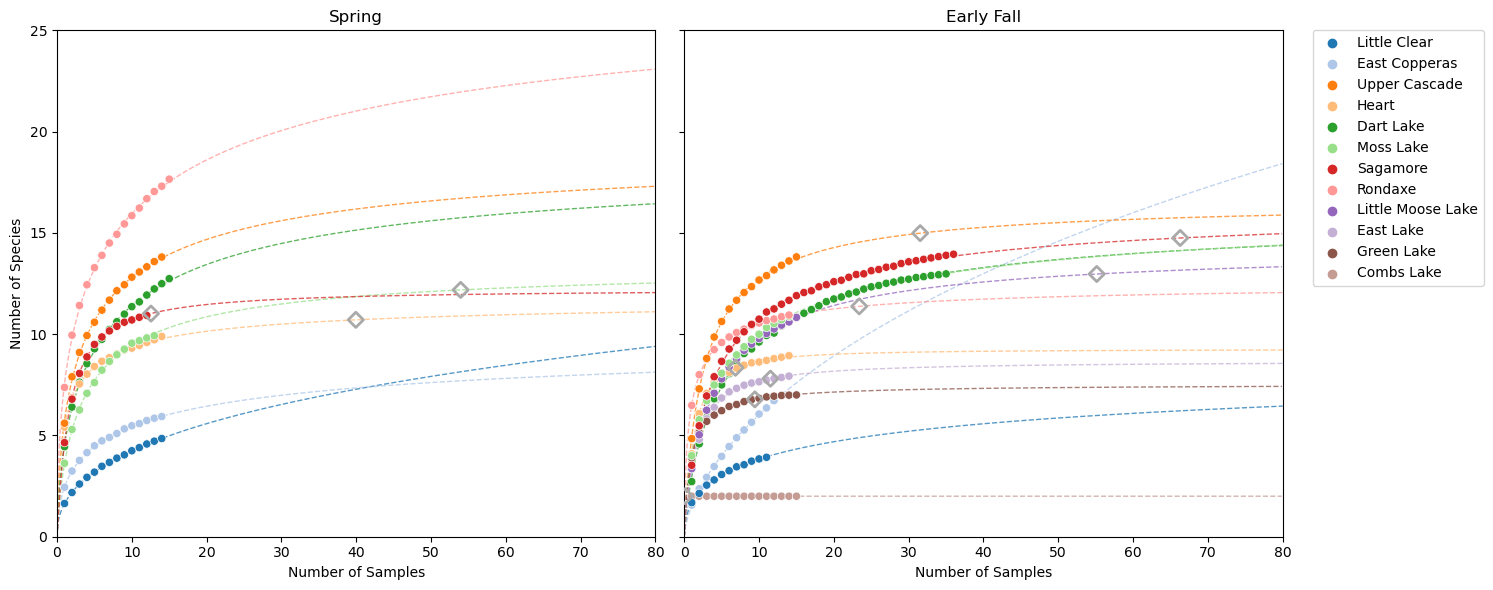

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i in all_lakes:
    try:
        sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
                         [fitted_data["Season"] == "Spring"]
                         [fitted_data["Number of Samples"] <= 80]).reset_index(drop=True), 
                   x = "Number of Samples", y = "Number of Species", palette = "tab20", linestyle='--',
                     hue = "Name", lw = 1, legend = False, hue_order=all_lakes, ax=axes[0], alpha = 0.75)
    except:
        pass
sns.scatterplot(data = plotting_accumulation[plotting_accumulation["Season"] == "Spring"].reset_index(drop=True), 
               x = "Number of Samples", y = "Number of Species", palette = "tab20",
                hue = "Name", zorder=7, ax=axes[0], legend = False, hue_order=all_lakes)#, legend = False)
ax1 = axes[0]
ax1.scatter(x = ninety["Number of Samples"][ninety["Season"] == "Spring"], 
            y = ninety["Number of Species"][ninety["Season"] == "Spring"],
                edgecolors = "darkgrey", marker = 'D', facecolors='none', 
            s = 60, zorder=8, lw=2.0)


for i in all_lakes:
    try:
        sns.lineplot(data = (fitted_data[fitted_data["Name"] == i]
                         [fitted_data["Season"] == "Early Fall"]
                         [fitted_data["Number of Samples"] <= 80]).reset_index(drop=True), 
                   x = "Number of Samples", y = "Number of Species", palette = "tab20", linestyle='--',
                     hue = "Name", lw = 1, legend = False, hue_order=all_lakes, ax=axes[1], alpha = 0.75)
    except:
        pass
sns.scatterplot(data = plotting_accumulation[plotting_accumulation["Season"] == "Early Fall"].reset_index(drop=True), 
               x = "Number of Samples", y = "Number of Species", palette = "tab20",
                hue = "Name", zorder=7, ax=axes[1], hue_order=all_lakes)
ax2 = axes[1]
ax2.scatter(x = ninety["Number of Samples"][ninety["Season"] == "Early Fall"], 
            y = ninety["Number of Species"][ninety["Season"] == "Early Fall"],
                edgecolors = "darkgrey", marker = 'D', facecolors='none', 
            s = 60, zorder=8, lw=2.0)


axes[0].set_title("Spring")
axes[1].set_title("Early Fall")
# Add legend (shared between both subplots)
axes[0].set_xlim(0, 80)
axes[0].set_ylim(0, 25)
axes[1].set_xlim(0, 80)
axes[1].set_ylim(0, 25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("../extrapolated_accumulation.pdf", dpi = 300)

In [462]:
lake = "Moss Lake"
season = "Early Fall"
tmp = (joined[metadata["EGCF-ID"]
              [metadata["Name"] == lake]
              [metadata["Season"] == season].tolist() + 
              ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
       [joined["Primer"] == "MiFish"]).fillna(0).reset_index(drop=True)
tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
    tmp1 = tmp[tmp["Overall_Best"] == i]
    if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
        tmp2 = tmp[tmp["Family"] == i]
        for col in tmp2.columns[:-5].tolist():
            tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
        tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
        if len(tmp2) == 2:
            sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
            tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
        tmp2 = tmp[tmp["Genus"] == i]
        for col in tmp2.columns[:-5].tolist():
            tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
        tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
        if len(tmp2) == 2:
            sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
            tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
tmp = tmp[tmp["sum"] > lowcov]
tmp = tmp[tmp.columns[:-1]]

/tmp/ipykernel_2238009/51089035.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)


In [460]:
fall = tmp.columns

In [456]:
lake = "Moss Lake"
season = "Spring"
tmp = (joined[metadata["EGCF-ID"]
              [metadata["Name"] == lake]
              [metadata["Season"] == season].tolist() + 
              ["Overall_Best", "Overall_Best_Taxonomic_Level", "Genus", "Family"]]
       [joined["Primer"] == "MiFish"]).fillna(0).reset_index(drop=True)
tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
tmp = tmp[tmp["sum"] > 0].reset_index(drop=True)
for i in tmp["Overall_Best"][tmp["Overall_Best_Taxonomic_Level"] != "Species"]:
    tmp1 = tmp[tmp["Overall_Best"] == i]
    if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Family':
        tmp2 = tmp[tmp["Family"] == i]
        for col in tmp2.columns[:-5].tolist():
            tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
        tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
        if len(tmp2) == 2:
            sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
            tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
    if tmp1["Overall_Best_Taxonomic_Level"].reset_index(drop=True)[0] == 'Genus':
        tmp2 = tmp[tmp["Genus"] == i]
        for col in tmp2.columns[:-5].tolist():
            tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)
        tmp2 = tmp2.loc[tmp2[tmp2.columns[:-5].tolist()].duplicated(keep=False)]
        if len(tmp2) == 2:
            sp = tmp2["Overall_Best"][tmp2["Overall_Best_Taxonomic_Level"] == "Species"].reset_index(drop=True)[0]
            tmp.loc[tmp["Overall_Best"] == i, "Overall_Best"] = sp
tmp = pd.concat([tmp[tmp.columns[:-4].tolist()].groupby('Overall_Best').transform('sum'), tmp["Overall_Best"]], axis = 1).drop_duplicates().reset_index(drop=True)
tmp = tmp.set_index("Overall_Best").T.reset_index(drop=False)
tmp['sum'] = tmp.sum(axis=1, numeric_only=True)
tmp = tmp[tmp["sum"] > lowcov]
tmp = tmp[tmp.columns[:-1]]

/tmp/ipykernel_2238009/3670080907.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2[col] = (tmp2[col].values > 0).astype(np.uint8)


In [457]:
spring = tmp.columns

In [463]:
tmp

Overall_Best index  Lepomis gibbosus  Perca flavescens  Micropterus salmoides  \
0              261               0.0          125955.0                    0.0   
1              262            9277.0           44285.0                69063.0   
2              263           41625.0           59008.0                37107.0   
3              264               0.0           48041.0                    0.0   
4              265           18100.0           30538.0                97812.0   
5              266               0.0               0.0                58499.0   
6              267           80807.0           46310.0                70707.0   
7              268           38334.0           59292.0                45126.0   
8              269               0.0               0.0                47720.0   
9              270           25928.0           86208.0                 5249.0   
10             271               0.0           61121.0               105051.0   
11             272               0.0          110126.0                71700.0   
12             273           42168.0           69199.0                62890.0   
14             275            4896.0               0.0                22491.0   
15             276           19924.0          108642.0                 4002.0   

Overall_Best  Salvelinus fontinalis  Catostomus commersonii  \
0                               0.0                 45572.0   
1                               0.0                     0.0   
2                               0.0                     0.0   
3                               0.0                 44284.0   
4                               0.0                  8478.0   
5                               0.0                119327.0   
6                               0.0                     0.0   
7                               0.0                 55912.0   
8                               0.0                 55241.0   
9                               0.0                 67676.0   
10                          50233.0                     0.0   
11                              0.0                     0.0   
12                              0.0                 22297.0   
14                              0.0                 50867.0   
15                              0.0                 18022.0   

Overall_Best  Semotilus atromaculatus  Umbra limi  Notemigonus crysoleucas  \
0                                 0.0         0.0                      0.0   
1                                 0.0         0.0                      0.0   
2                                 0.0         0.0                      0.0   
3                                 0.0         0.0                      0.0   
4                                 0.0     14233.0                  18374.0   
5                                 0.0         0.0                      0.0   
6                                 0.0         0.0                      0.0   
7                                 0.0         0.0                      0.0   
8                                 0.0         0.0                      0.0   
9                                 0.0         0.0                      0.0   
10                                0.0         0.0                      0.0   
11                                0.0         0.0                      0.0   
12                                0.0     15075.0                  12216.0   
14                                0.0         0.0                   2396.0   
15                            21561.0         0.0                      0.0   

Overall_Best  Ameiurus nebulosus  Osmerus mordax  Sander vitreus  
0                          946.0             0.0             0.0  
1                         4306.0             0.0             0.0  
2                            0.0             0.0             0.0  
3                        50812.0             0.0             0.0  
4                            0.0             0.0             0.0  
5                            0.0           

In [465]:
metadata[metadata["EGCF-ID"] == "268"]

Name       Date      Season  ALSC   Time Site Description EGCF-ID  \
265  Moss Lake  9/26/2023  Early Fall     0  12:10   3A  Near Shore     268   

    Replicate  Latitude Longitude  Water Depth eDNA  Vol. Filtered (ml)  \
265         1  43.78312  -74.8513          1.1    x               150.0   

     eDNA Depth (m)  Temp at Depth  DO at Depth  Secchi Depth (M) Notes  \
265             0.0           17.5          8.8               4.5   NaN   

                   Merged  
265  Moss Lake_Early Fall

In [447]:
[i for i in fall if i not in spring]

['Micropterus salmoides']

In [448]:
[i for i in spring if i not in fall]

['Lepomis gibbosus', 'Salvelinus fontinalis']

In [449]:
fall

Index(['Micropterus salmoides', 'Catostomus commersonii',
       'Semotilus atromaculatus', 'Notemigonus crysoleucas',
       'Ameiurus nebulosus', 'Chrosomus neogaeus', 'Rhinichthys atratulus',
       'Chrosomus eos', 'Couesius plumbeus'],
      dtype='object', name='Overall_Best')